<a id="top"></a>
## Table of Contents
* [0. Project Description](#0)
* [1. Libraries](#1)
* [2. Data Collection](#2)
    - [2.1 Data Scraper](#2.1)
    - [2.2 An Overview of the Data](#2.2)
* [3. Exploratory Data Analysis](#3) 
    - [3.1 Statistics](#3.1)
    - [3.2 Common Words for Aspects](#3.2)
    - [3.3 Summary](#3.3)
* [4. Data Module](#4)
    - [4.1 Pre-processing](#4.1)
        - [4.1.1 Overview](#4.1.1)
        - [4.1.2 GloVe](#4.1.2)
    - [4.2 Data Split](#4.2)
* [5. Model Module](#5)
    - [5.1 MLP](#5.1)
    - [5.2 RNN](#5.2)
    - [5.3 TextCNN](#5.3)
    - [5.4 Transformer](#5.4)
    - [5.5 BERT](#5.5)
* [6. Results](#6)
* [7. Conclusion & Future Development](#7)

The source code and basic project setup are available at https://github.com/YanZehong/CS5242-ABSC

##  0. <a name='0'></a>Project Description
[Back to Table of Contents](#top)

With the proliferation of user-generated content on the web, such as online reviews and social media, interest in mining sentiment information in text has grown rapidly, both in academia and business. Mining these opinionated texts to accurately assess what people think toward a certain entity is important for companies to improve their products or services. Previous work in sentiment analysis aimed to predict an overall polarity or rating of a given text span, which may not be the case in practice. The need for a more fine-grained approach, known as aspect-based sentiment analysis (ABSA), became apparent. For example, the benchmark dataset from SemEval uses five aspects (FOOD, SERVICE, PRICE, AMBIENCE, MISC.) for the restaurant domain. These aspects can help customer service better understand what are the major pros and cons. Generally, the ABSA task involves the identification/detection of various aspect-level sentiment elements (e.g., aspect terms, aspect categories and opinion terms), and the classification of sentiment polarities. In this project, we focus on the aspect-based sentiment classification (ABSC). To be specific, the sentence “The restaurant was expensive, but the food was great” would be assigned with a negative polarity for the aspect PRICE, whereas the aspect FOOD has positive polarity.

We formulate the ABSC task as follows. Given a input sequence $X = {𝑥_1, 𝑥_2, ..., 𝑥_𝑁 }$ with length $N$ and a predefined aspect list $ A = {a_1, a_2, ..., 𝑎_K} $, our task is to predict the sentiment polarity $y \in {𝑝𝑜𝑠𝑖𝑡𝑖𝑣𝑒, 𝑛𝑒𝑔𝑎𝑡𝑖𝑣𝑒, 𝑛𝑒𝑢𝑡𝑟𝑎𝑙}$ for each aspect 𝑎𝑘 mentioned inside the text.

##  1. <a name='1'></a>Libraries
[Back to Table of Contents](#top)

In [1]:
%matplotlib inline
import os
import math
import json
import pickle
import collections
import random
import copy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
stopwords_list = stopwords.words('english')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
import seaborn as sns
import plotly
import plotly.graph_objs as go
from IPython import display

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers.optimization import get_cosine_schedule_with_warmup
from data_utils import parse_dataset, build_tokenizer, build_glove_embeddings, ABSCProcessor, plot_ngram
from utils import Timer, Accumulator, Animator, try_all_gpus, accuracy, evaluate_loss_and_acc_gpu, test, test_on_checkpoint, read_and_calculate


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

##  2. <a name='2'></a>Data Collection
[Back to Table of Contents](#top)

For data collection, we first collected about 6000 reviews data for the first time. However, after data analysis, we found that the distribution and proportion of the data were seriously uneven.The main problem is that the negative and neutral data are seriously insufficient, and the second is that the data of some aspects is also seriously insufficient. So we scoured multiple websites, controlling the data tags for each crawl, and finally got our current dataset.

###  2.1 <a name='2.1'></a> Data Scraper
Please check `DataScraper.ipynb` for further details. We conduct our experiments on the dataset scraped from TripAdvisor (https://www.tripadvisor.com/) which contains six aspects (value, location, service, rooms, cleanliness, sleep quality). Ratings of each review are on scales of 1 to 5. We convert original scales to sentiment polarities as follows: 1 and 2 stars are treated as negative; 3 is neutral; 4 and 5 stars are treated as positive. 

###  2.2 <a name='2.2'></a> An Overview of the Data

In [2]:
df = pd.read_excel('dataset/TripAdvisor/all_scrap_data.xlsx')
print(f'#texts: {len(df)}')
print(df.info())
df.head()

#texts: 9828
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9828 entries, 0 to 9827
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   overall        9828 non-null   int64  
 1   title          9828 non-null   object 
 2   review         9828 non-null   object 
 3   date           9828 non-null   object 
 4   Value          7382 non-null   float64
 5   Location       7383 non-null   float64
 6   Service        9815 non-null   float64
 7   Rooms          7242 non-null   float64
 8   Cleanliness    7307 non-null   float64
 9   Sleep Quality  7186 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 767.9+ KB
None


,overall,title,review,date,Value,Location,Service,Rooms,Cleanliness,Sleep Quality
0,30,Zero customer service experience,Very expensive and no customer service.No rest...,Date of stay: October 2022,10.0,30.0,10.0,30.0,40.0,30.0
1,10,Stay somewhere else,"No customer service! Staff is unavailable, no ...",Date of stay: October 2022,10.0,30.0,10.0,20.0,10.0,30.0
2,10,Awful,No place to eat other than a crowded mini mart...,Date of stay: October 2022,10.0,10.0,10.0,20.0,30.0,10.0
3,20,Would not stay again,For the cost of the room I am sure there are b...,Date of stay: September 2022,10.0,30.0,10.0,30.0,30.0,30.0
4,10,"Old, tired hotel that is not worth the money",I had to stay at this Hyatt to attend UNGA. It...,Date of stay: September 2022,10.0,10.0,10.0,10.0,10.0,10.0


In [3]:
# label mapping
label_map = {10: 0, 20: 0, 30: 1, 40: 2, 50:2} # 0: negative, 1: neutral, 2: positive
cols = [df.columns[0]] + list(df.columns[4:])
for i, col in enumerate(cols):
    df[col] = df[col].map(label_map)
df.fillna(-1, inplace=True)
df.head()

,overall,title,review,date,Value,Location,Service,Rooms,Cleanliness,Sleep Quality
0,1,Zero customer service experience,Very expensive and no customer service.No rest...,Date of stay: October 2022,0.0,1.0,0.0,1.0,2.0,1.0
1,0,Stay somewhere else,"No customer service! Staff is unavailable, no ...",Date of stay: October 2022,0.0,1.0,0.0,0.0,0.0,1.0
2,0,Awful,No place to eat other than a crowded mini mart...,Date of stay: October 2022,0.0,0.0,0.0,0.0,1.0,0.0
3,0,Would not stay again,For the cost of the room I am sure there are b...,Date of stay: September 2022,0.0,1.0,0.0,1.0,1.0,1.0
4,0,"Old, tired hotel that is not worth the money",I had to stay at this Hyatt to attend UNGA. It...,Date of stay: September 2022,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df.to_csv('dataset/TripAdvisor/cleaned_data.csv')

##  3. <a name='3'></a>Exploratory Data Analysis
[Back to Table of Contents](#top)

###  3.1 <a name='3.1'></a> Statistics

#### 3.1.1 Overall Sentiment == Aspect Sentiment ?
Accordingly, there are 80.09% of aspect ratings are different from overall value, which means the overall value is not reliable for estimating the emotional tendencies of the whole review. In practice, aspects can help companies better understand what are the major pros and cons of their product or service. Hence, aspect-based sentiment analysis provides a way to analyse public sentiments over time across different contents present on social media. In this study, we aim to predict the sentiment polarity of each identified aspect inside a sentence or a text. For example, the sentence “The pizza is yummy and I like the atmosphere” would be assigned with a positive polarity for the aspect food and the aspect ambience, respectively. But we will deal with much longer input text instead of simple sentence.


In [4]:
cnt = 0
df_compare=pd.DataFrame({})
for i, col in enumerate(df.columns[4:]):
    df_compare[col] = np.where(df['overall']==df[col],'same','different')
for i in range(len(df_compare)):
    if all([s=='same' for s in list(df_compare.iloc[i])]): cnt += 1
print(f'The percentage of reviews with the same sentiment between overall and all aspects {cnt/len(df_compare)*100 :.2f}%')

The percentage of reviews with the same sentiment between overall and all aspects 19.91%


#### 3.1.2 Distribution of Labels

In [19]:
def summary_aspects(df):
    '''output data statistic/distribution for each aspect'''
    labels = [-1, 0, 1, 2]
    temp = {'labels': labels}
    for i, col in enumerate(df.columns[4:]):
        temp_aspect = df.groupby(col).count()['review'].reset_index()
        temp_aspect.columns = ['label', col]
        cnts = []
        for la in labels:
            if temp_aspect[temp_aspect['label']==la].empty:
                cnts.append(0)
            else:
                cnts.append(temp_aspect[temp_aspect['label']==la][col].values[0])
        temp[col] = cnts
    df_aspects = pd.DataFrame(temp)
    df_aspects= df_aspects.drop(index=[0])
    df_aspects['sum']=df_aspects.apply(lambda x:x.sum(),axis =1)
    df_aspects_ratio = pd.DataFrame()
    for i, col in enumerate(df_aspects.columns[1:]):
        df_aspects_ratio[col]=df_aspects[col]/sum(df_aspects[col])
    return df_aspects, df_aspects_ratio

df_aspects, df_aspects_ratio = summary_aspects(df)

In [15]:
df_aspects

,labels,Value,Location,Service,Rooms,Cleanliness,Sleep Quality,sum
1,0,2393,836,2803,2361,1869,1491,11753
2,1,1234,2231,1353,1027,1089,906,7841
3,2,3345,4316,5618,3432,3946,3699,24358


In [21]:
df_aspects_ratio

,Value,Location,Service,Rooms,Cleanliness,Sleep Quality,sum
1,0.343230,0.113233,0.286781,0.346188,0.270713,0.244587,0.267405
2,0.176994,0.302181,0.138428,0.150587,0.157735,0.148622,0.178399
3,0.479776,0.584586,0.574790,0.503226,0.571553,0.606791,0.554195


#### 3.1.3 Distribution of Document Lengths

Average reiview length: 142.13512413512413


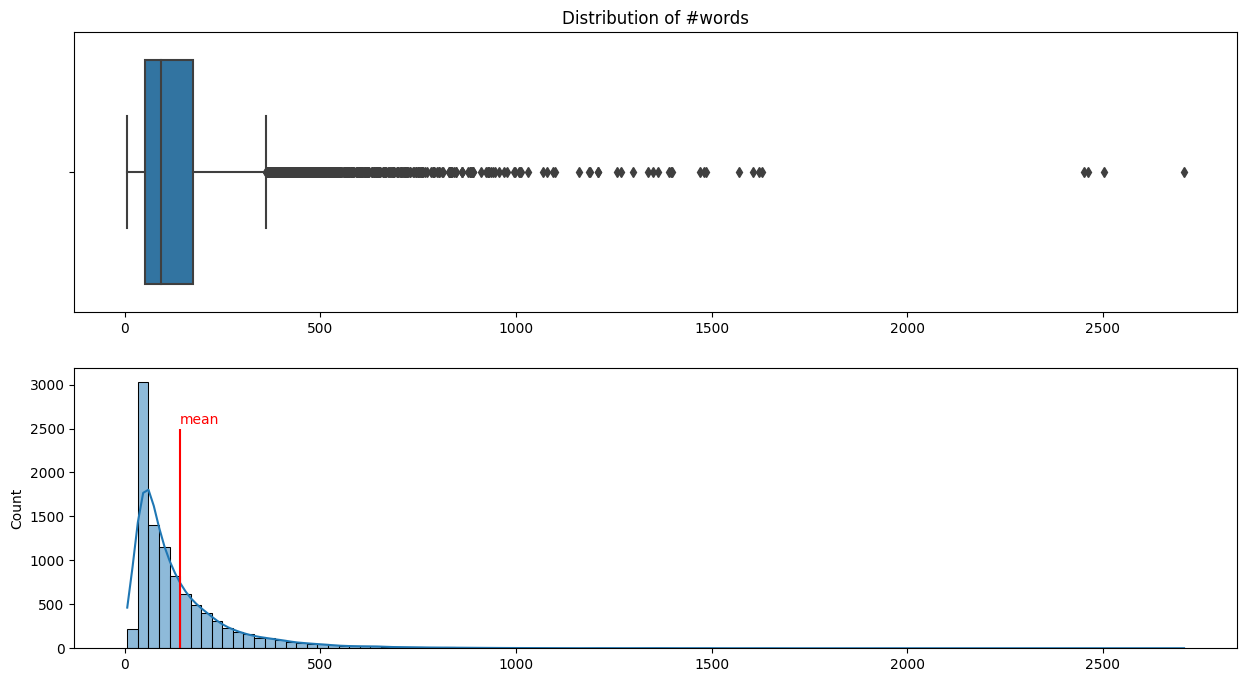

In [24]:
texts = df['review']
text_lens = [len(t.split()) for t in texts.values]
len_mean = np.mean(text_lens)
print(f"Average reiview length: {len_mean}")
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of #words')
sns.boxplot(x=text_lens, ax=axes[0])
sns.histplot(data=text_lens, bins=100, kde=True, ax=axes[1])
axes[1].vlines(len_mean, 0, 2500, color = 'r')
plt.annotate("mean", xy=(len_mean, 2500), xytext=(len_mean-2, 2550), color='r')
plt.show()

### 3.2  <a name='3.2'></a> Common Words for Different Aspects

In [33]:
# top words
tw_aspects = {}
pattern = re.compile('[^\w ]') # used to remove special characters from the string.
for col in cols:
    word_counts = collections.defaultdict(list)
    for text, t in zip(df['review'], df[col]):
        if t == -1: continue
        text = re.sub(pattern, '', text).lower().split()
        text = [word for word in text if word not in stopwords_list]
        word_counts[t].extend(text)
    tw_aspects[col] = (word_counts)

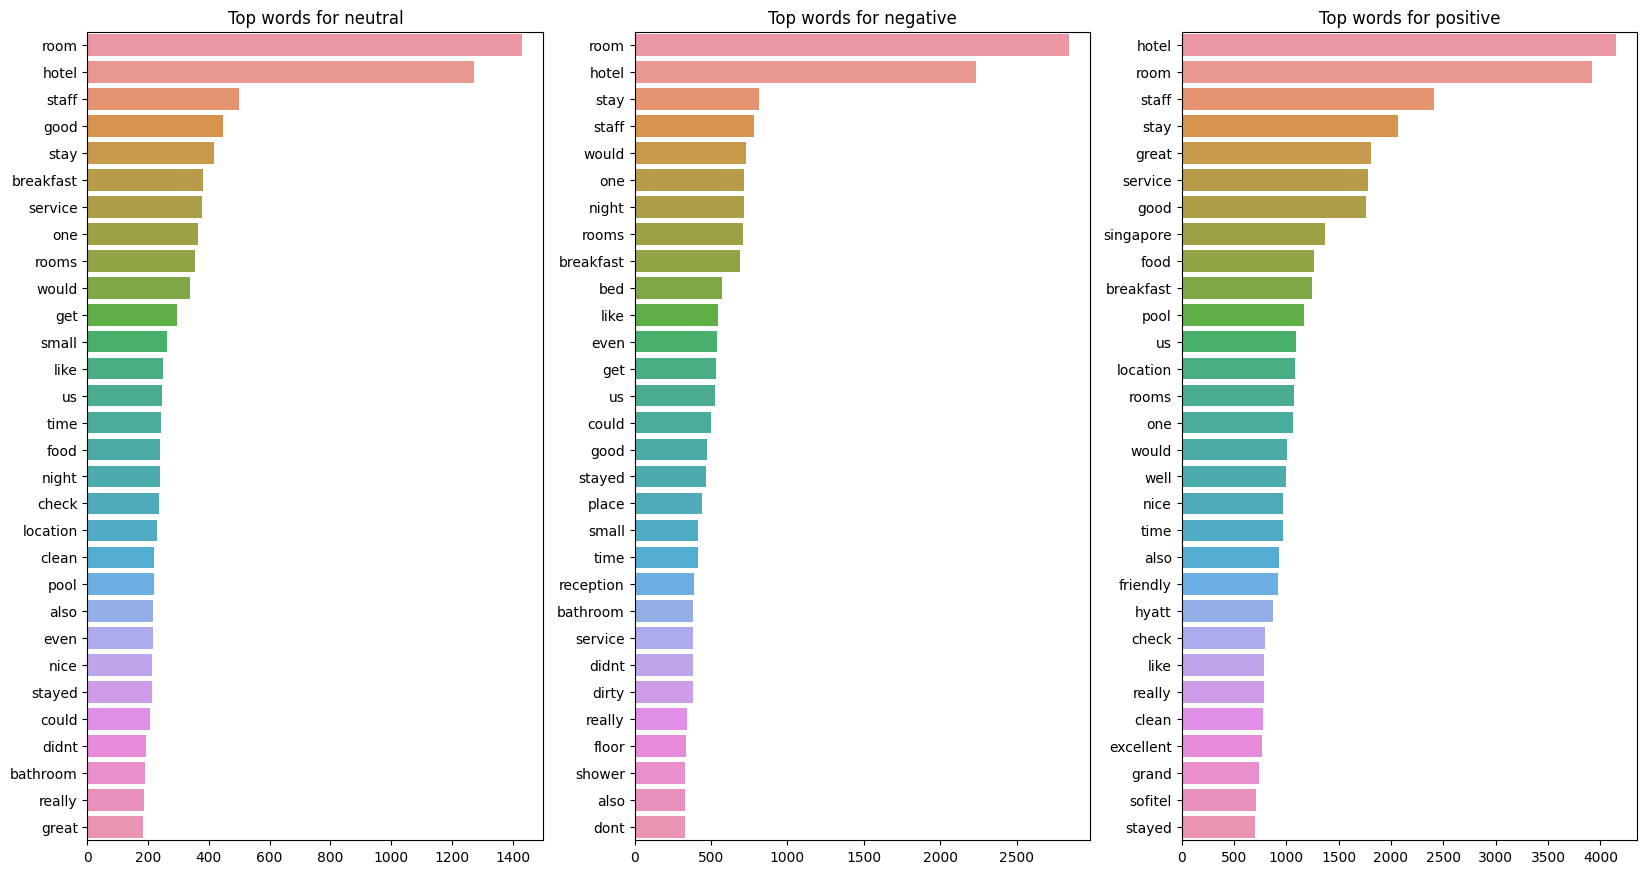

In [34]:
# display top-k topwords for a specific aspect
k = 30
aspect_name = 'Sleep Quality' # 'overall', 'Value', 'Location', 'Service', 'Rooms', 'Cleanliness', 'Sleep Quality'
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
word_counts = tw_aspects[aspect_name]
fig, axes = plt.subplots(1, 3, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:k]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {sentiment_map[target]}')
plt.show()

<Figure size 2000x2000 with 0 Axes>

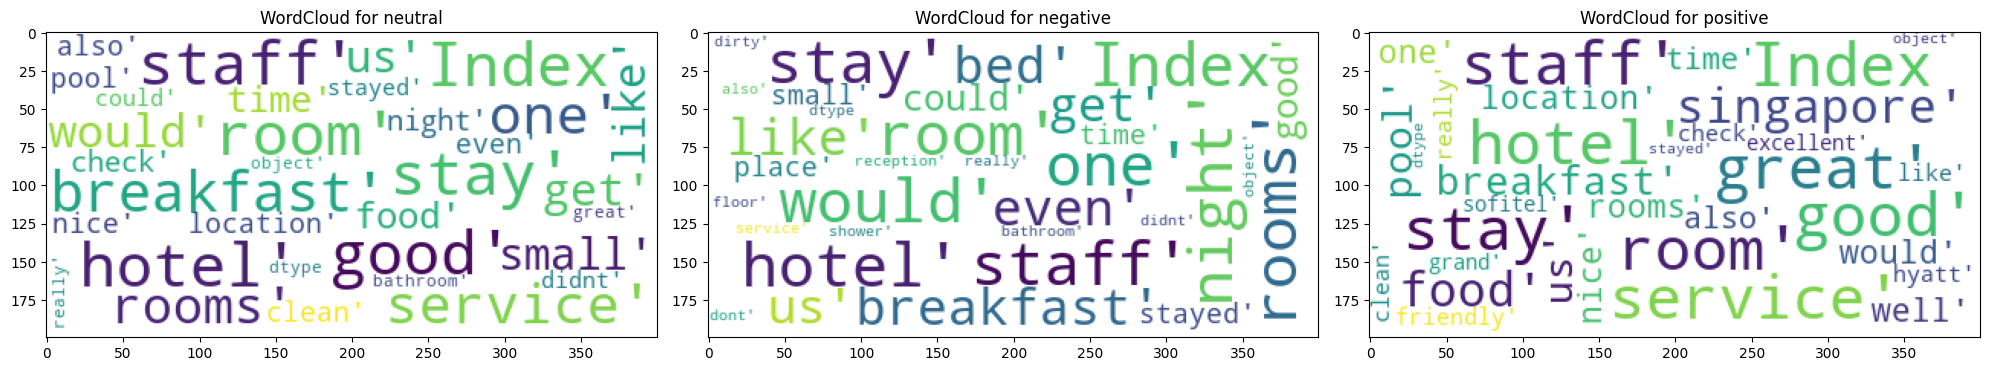

In [37]:
plt.figure(figsize = (20,20))
stopwords = set(STOPWORDS)
more_stopwords = {'u', "im"}
stopwords = stopwords.union(more_stopwords)
fig, axes = plt.subplots(1, 3, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:k]
    wordcloud = WordCloud(background_color = 'white',stopwords=stopwords,max_words = 1000,\
                      max_font_size = 40,random_state = 42).generate(str(bar_info.index))
    axis.imshow(wordcloud)
    axis.set_title(f'WordCloud for {sentiment_map[target]}')

plt.tight_layout()  

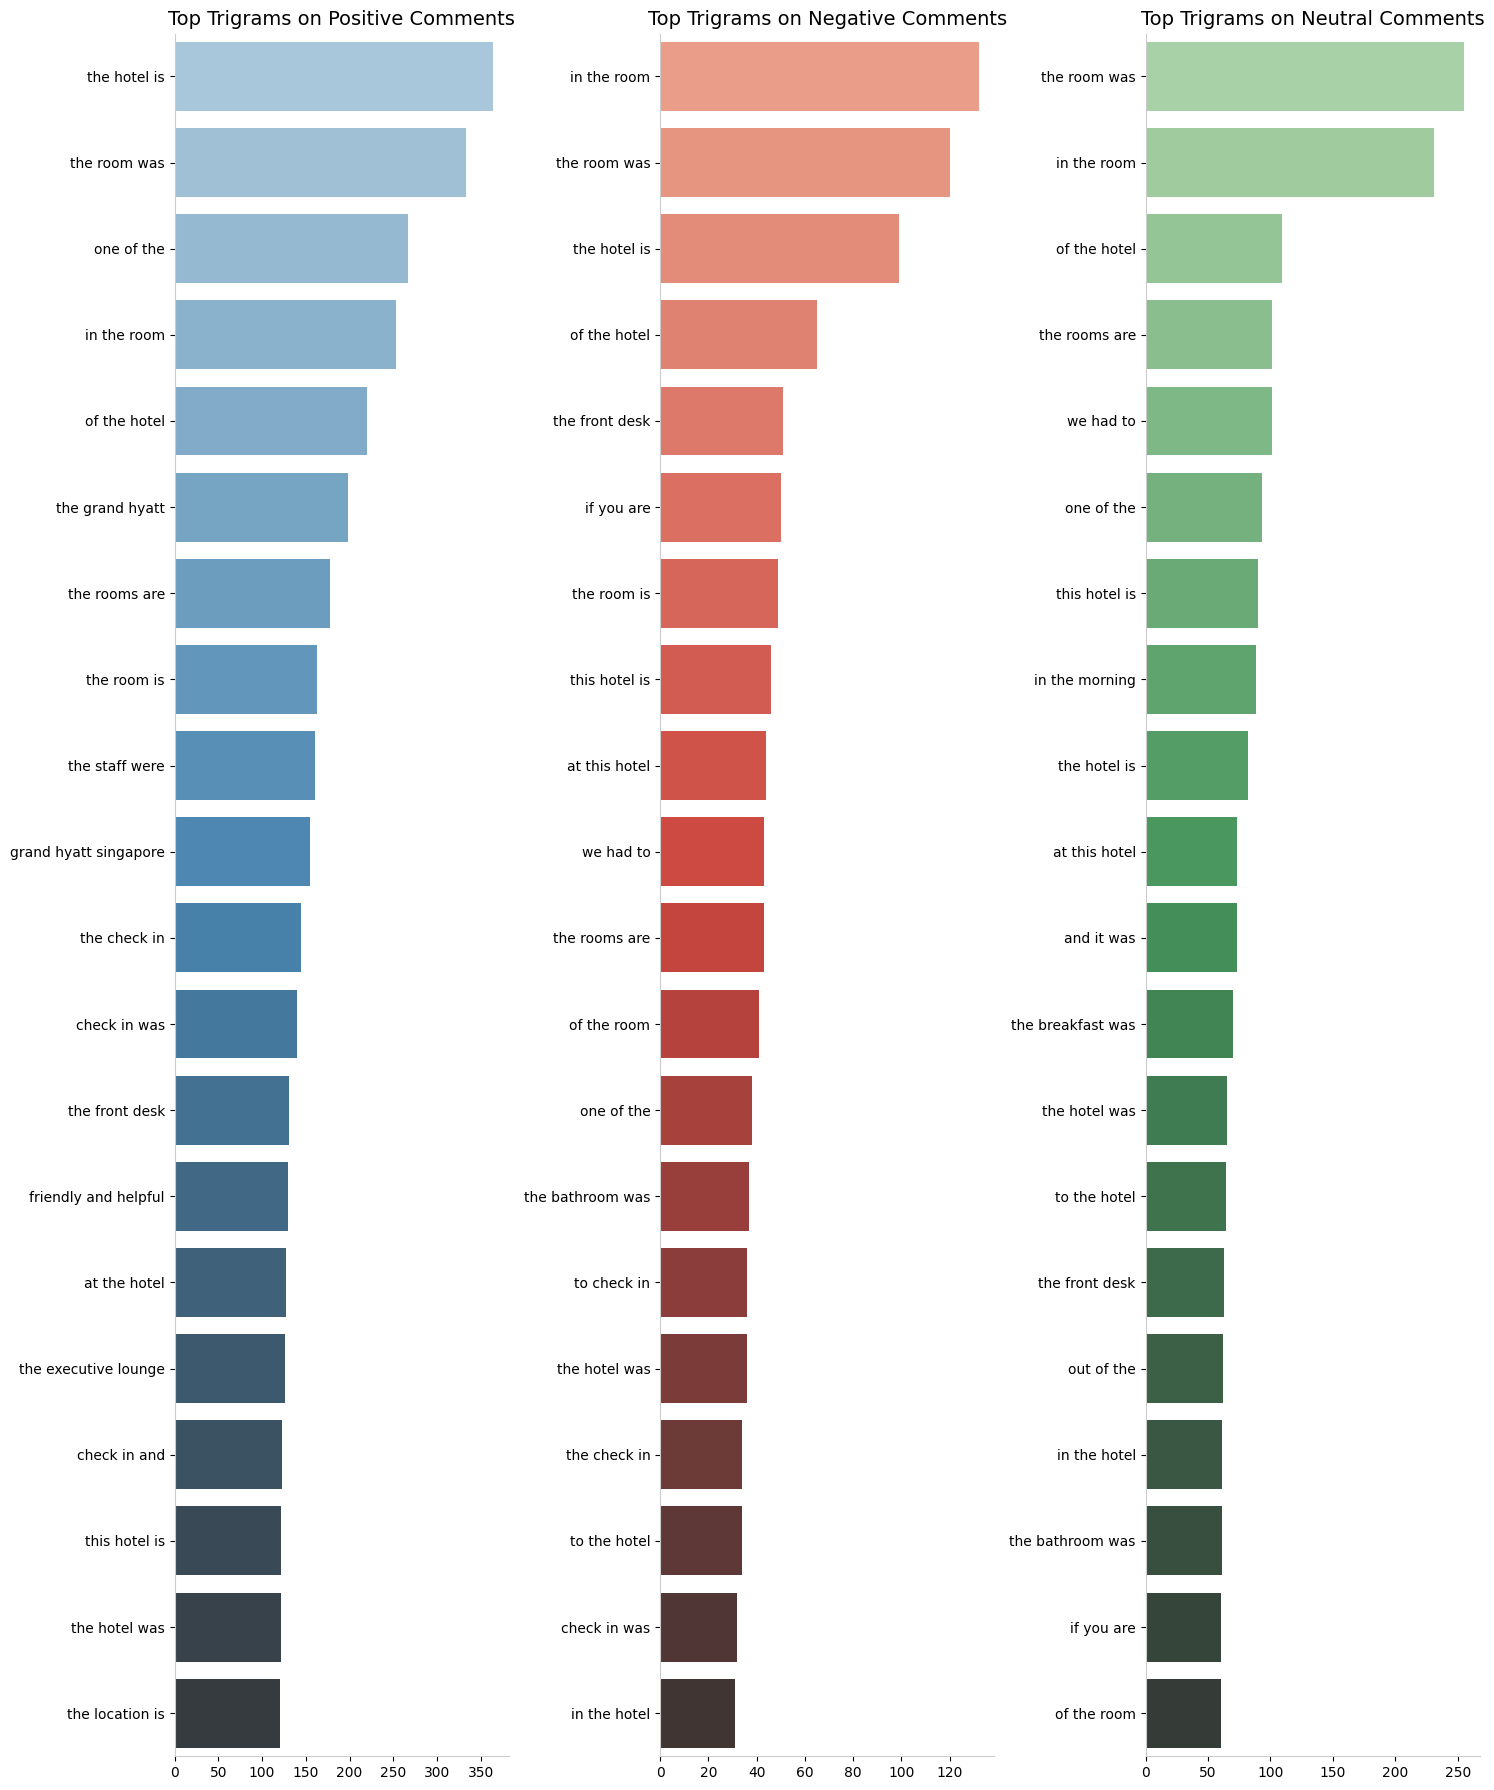

In [4]:
plot_ngram(df, 'Sleep Quality', 20)

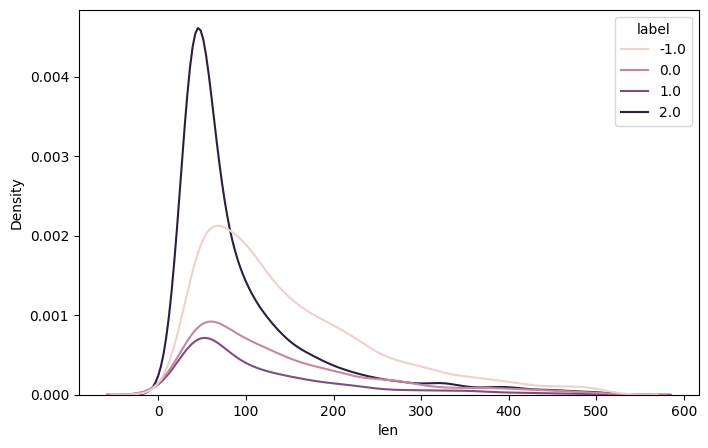

In [39]:
# display length distribution for a specific aspect
aspect_name = 'Sleep Quality' # 'overall', 'Value', 'Location', 'Service', 'Rooms', 'Cleanliness', 'Sleep Quality'
text_len = collections.defaultdict(list)
pattern = re.compile('[^\w ]')
text_len = pd.DataFrame([len(re.sub(pattern, '', text).lower().split()) for text in df['review']], columns=['len'])
text_len['label'] = df[aspect_name]
text_len = text_len[text_len['len']<512]
plt.figure(figsize=(8, 5))
sns.kdeplot(data=text_len, x='len', hue='label')
plt.show()

As distribution figures show, most reviews have less than 200 words, while few of them have more than 400 words, which will cause little impact on the training result. To ensure our accuracy of training, we need to select a specific length of words for each text. If the selected length of words is too large, the information of each word would have a very little impact on training; otherwise, training process may lose a lot of important information since we have drop too many word in a text.

###  3.3<a name='3.3'></a> Summary
In this section, we analyzed the most frequent words shown in each aspect, which will help us have an intuitive understanding of how emotional words affect the semantic direction of the reviews, and also this indicates that some words in the sentence could be evidence of sentiment classification.
 
As for the figures of all aspects, 'room' and 'hotel' are most frequent words, and much more than other words, which is because these words are most related to our topic— reviews of hotels.
 
On top words list of positive labels, the most frequent words for positive reviews are 'excellent', 'great', 'clean' and 'friendly' which convey positive attitudes, while 'dirty', 'small' and 'bathroom' are on the top of the negative list.
 
The great difference between positive and negative lists shows that aspects of words could reflect the emotional tendency of a sentence.
 
For sleep quality, 'location' and 'pool' shows frequently on the list of positive and neutral list but does not appear on negative one, which means that they may have great influence on good reviews of sleep quality; 'reception' and 'bathroom' may affect a lot on bad reviews of sleep quality since they only on the list of negative comments.

For price of hotel, 'singapore' appears most in positive label list but did not appear on other label lists, which means that customers tends to signify ranges when they feel good for the price; while 'night', 'bed' and 'bathroom' are only on the top list of negative and neutral list, implying people are more likely to make bad comments when referring to these words. Besides, Sofitel and hyatte appear a lot on the positive list, implying that these two hotels provide better living experience at lower price.

For service attitude, 'food', 'rice' and 'dean' are the ones that did not appear on the list of negative but are on the positive list, showing that these things may be more related to good service comments. Whereas, 'reception' 'check' and 'night' may indicate more about negative reviews.
 
Speaking of rooms, 'grand', 'nice' and 'clean' are frequent appearing words, which are words discerning good rooms; on the contrary, 'dirty' and 'small' are on the list of negative reviews since they also explain bad rooms.
 
Speaking of Cleanliness, there is no doubt that 'dirty' is on the negative list and 'clean' is on the positive list. Some specific words like 'floor', 'bathroom' and 'shower' are also listed for negative comments, which indicate that customers may point out the specific reason when complaining.
 
For location, the positive words are more than those in other aspects of the positive list, but some positive words also appear on the negative list, which may be due to people tends to use negation such as not no to express their negative feelings.
 
In conclusion, aspect words could reflect the semantic direction of the whole sentence.

##  4. <a name='4'></a>Data Module
[Back to Table of Contents](#top)

##  4.1 <a name='4.1'></a>Pre-processing

###  4.1.1 <a name='4.1.1'></a> Overview
![architecture](images/overview.png)

###  4.1.2 <a name='4.1.2'></a> GloVe
Full name: Global vector for word representation   
The global corpus statistics are captured directly by the model. It starts working by building a large matrix which consists of the words co-occurrence information, basically, The idea behind this matrix is to derive the relationship between the words from statistics. The co-occurrence matrix tells us the information about the occurrence of the words in different pairs. And by using the matrix we can compute the ratio of probabilities between any two pairs of words: $\frac{P_{ik}}{P_{jk}}$. Eventually we can find a map f : $f(i,j,k) = \frac{P_{ik}}{P_{jk}}$ to characterize the relationship between word vectors and co-occurrence probability ratio.

Advantage:
The gloVe benefits that, unlike Word2vec, it does not rely solely on local statistics (local context information of words) to generate word vectors but also incorporates worldwide statistics (word co-occurrence).

Reference:  
https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/lectures/midterm-review.pdf  
https://nlp.stanford.edu/pubs/glove.pdf

Thanks to https://nlp.stanford.edu/projects/glove/. Here we will use GloVe pretrained corpus model to represent our words with 300 dimensional vectors for all all models except BERT. Further deatils are provided in `Glove_note_luojian.pdf`

##  4.2 <a name='4.2'></a>Data Split

In [58]:
df = pd.read_csv("dataset/TripAdvisor/cleaned_data.csv")
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)
df_train, df_dev = train_test_split(df_train, test_size=0.1, random_state=42, shuffle=True)
df_train.to_csv("dataset/TripAdvisor/train.csv", index=False)
df_dev.to_csv("dataset/TripAdvisor/dev.csv", index=False)
df_test.to_csv("dataset/TripAdvisor/test.csv", index=False)
len(df_train), len(df_test), len(df_test)

(7960, 983, 983)

In [2]:
print("Load traning corpus:")
train_corpus=parse_dataset('dataset/TripAdvisor/', 'train')
with open("dataset/TripAdvisor/train.json", "w") as fw:
    json.dump({line["id"]: line for line in train_corpus}, fw, sort_keys=True, indent=4)
    
print("Load development corpus:")
dev_corpus=parse_dataset("dataset/TripAdvisor/", "dev")
with open("dataset/TripAdvisor/dev.json", "w") as fw:
    json.dump({line["id"]: line for line in dev_corpus}, fw, sort_keys=True, indent=4)
    
print("Load testing corpus:")
test_corpus=parse_dataset("dataset/TripAdvisor/", "test")
with open("dataset/TripAdvisor/test.json", "w") as fw:
    json.dump({line["id"]: line for line in test_corpus}, fw, sort_keys=True, indent=4)

Load traning corpus:
distribution of [negative, neutral, positive]: [ 9533.  6363. 19715.]
ratio: [26.8%, 17.9%, 55.4%]
#examples: 35611
Load development corpus:
distribution of [negative, neutral, positive]: [1004.  678. 2247.]
ratio: [25.6%, 17.3%, 57.2%]
#examples: 3929
Load testing corpus:
distribution of [negative, neutral, positive]: [1216.  799. 2394.]
ratio: [27.6%, 18.1%, 54.3%]
#examples: 4409


In [2]:
class ABSCDataset(Dataset):
    """Build dataset and convert examples to features"""
    def __init__(self, name, examples, tokenizer):
        self.name = name
        self.examples = examples
        self.tokenizer = tokenizer
        self.convert_data_to_features()
    
    def convert_data_to_features(self):
        """convert examples to features"""
        label_map = {0: 0, 1: 1, 2: 2}
        aspect_map = {"value":0, "location":1, "service":2, "room":3, "clean":4, "sleep":5}

        output = []
        for (i, example) in enumerate(tqdm(self.examples)):
            input_ids = self.tokenizer.convert_tokens_to_ids(example.text)
            aspect_token_id = self.tokenizer.word2idx[example.aspect]
            aspect_id = aspect_map[example.aspect]
            label_id = label_map[example.label]
            attention_mask = np.zeros(input_ids.shape, dtype=bool)
            position_ids = np.zeros(input_ids.shape)
            for i in range(len(input_ids)):
                if input_ids[i] == 0: 
                    attention_mask[i] = True
                else:
                    position_ids[i] = i+1

            
            feature = {
                "input_ids": input_ids,
                "aspect_token_id": aspect_token_id,
                "attention_mask": attention_mask,
                "position_ids": position_ids,
                "aspect_id": aspect_id,
                "label_id": label_id
            }
            output += [feature]
        self.data = output
        
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [3]:
print("Processing the Dataset")
data_dir="dataset"
data_name = "TripAdvisor"
datset_path = os.path.join(data_dir, data_name)
processor = ABSCProcessor(data_dir, data_name)
aspects = processor.get_aspects()
num_classes = len(processor.get_labels())
train_examples = processor.get_examples("train")
dev_examples = processor.get_examples("dev")
test_examples = processor.get_examples("test")

max_seq_len = 500
tokenizer = build_tokenizer(all_examples = [train_examples, dev_examples, test_examples], 
                            aspects = aspects, 
                            max_seq_len = max_seq_len,
                            dat_fname = datset_path+'/tokenizer_{0}.dat'.format(max_seq_len))

embedding_matrix = build_glove_embeddings(
                word2idx = tokenizer.word2idx,
                dat_fname = datset_path+'/glove_300d_embeddings.dat')

train_data = ABSCDataset(data_name, train_examples, tokenizer)
dev_data = ABSCDataset(data_name, dev_examples, tokenizer)
test_data = ABSCDataset(data_name, test_examples, tokenizer)

Processing the Dataset
loading tokenizer: dataset/TripAdvisor/tokenizer_500.dat
Loading embedding_matrix: dataset/TripAdvisor/glove_300d_embeddings.dat


  0%|          | 0/35611 [00:00<?, ?it/s]

  0%|          | 0/3929 [00:00<?, ?it/s]

  0%|          | 0/4409 [00:00<?, ?it/s]

##  5. <a name='5'></a>Model Module
[Back to Table of Contents](#top)

In [4]:
def train_batch(net, batch, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs"""
    if isinstance(batch, dict):
        for k, v in batch.items():
            batch[k] = batch[k].to(devices[0])
    else:
        batch = batch.to(devices[0])
    y = batch['label_id']
    net.train()
    trainer.zero_grad()
    pred = net(**batch)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    args.learning_rates.append(trainer.param_groups[0]["lr"]) # used to track scheduler
    return train_loss_sum, train_acc_sum

def train(net, train_iter, valid_iter, num_epochs, optimizer, lr, wd, lr_period, lr_decay, devices):
    if optimizer == 'sgd':
        trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif optimizer == 'adam':
        trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    elif optimizer == 'adamw':
        trainer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)
        
    model_name = str(net.__class__.__name__)  
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    
    loss = nn.CrossEntropyLoss(reduction="none")
    timer = Timer()
    num_batches = len(train_iter)
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend += ['valid loss', 'valid acc']
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend, figsize=(7, 5))
    
    if args.monitor == 'loss':
        monitor_val = math.inf
    else:
        monitor_val = -math.inf
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(4)
        for i, batch in enumerate(train_iter):
            timer.start()
            labels = batch['label_id']
            output = train_batch(net, batch, loss, trainer, devices)
            metric.add(output[0], output[1], labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None, None))
        if valid_iter is not None:
            valid_loss, valid_acc = evaluate_loss_and_acc_gpu(net, valid_iter, loss, devices[0])
            animator.add(epoch + 1, (None, None, valid_loss, valid_acc))
            if args.monitor == 'loss':
                if valid_loss < monitor_val:
                    filename = model_name + f"-epoch{epoch}-val_loss{valid_loss :.2f}.pt"
                    best_model_state = copy.deepcopy(net.state_dict())
                    monitor_val = valid_loss
            else:
                if valid_acc > monitor_val:
                    filename = model_name + f"-epoch{epoch}-val_acc{valid_acc :.2f}.pt"
                    best_model_state = copy.deepcopy(net.state_dict())
                    monitor_val = valid_acc
        scheduler.step()
        
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
    args.pt_path = os.path.join("checkpoints", filename)
    torch.save(best_model_state, args.pt_path)
    animator.save("images", model_name + f"-train_loss{metric[0] / metric[2]:.2f}.png")
    

def train_transformer(net, train_iter, valid_iter, num_epochs, optimizer, lr, wd, num_warmup_steps, devices):
    if optimizer == 'sgd':
        trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif optimizer == 'adam':
        trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    elif optimizer == 'adamw':
        trainer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)
        
    model_name = str(net.__class__.__name__)
    scheduler = get_cosine_schedule_with_warmup(trainer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epochs*len(train_iter))
    
    loss = nn.CrossEntropyLoss(reduction="none")
    timer = Timer()
    num_batches = len(train_iter)
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend += ['valid loss', 'valid acc']
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend, figsize=(7, 5))
    
    if args.monitor == 'loss':
        monitor_val = math.inf
    else:
        monitor_val = -math.inf
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(4)
        for i, batch in enumerate(train_iter):
            timer.start()
            labels = batch['label_id']
            output = train_batch(net, batch, loss, trainer, devices)
            scheduler.step()
            metric.add(output[0], output[1], labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None, None))
            
            
        if valid_iter is not None:
            valid_loss, valid_acc = evaluate_loss_and_acc_gpu(net, valid_iter, loss, devices[0])
            animator.add(epoch + 1, (None, None, valid_loss, valid_acc))
            if args.monitor == 'loss':
                if valid_loss < monitor_val:
                    filename = model_name + f"-epoch{epoch}-val_loss{valid_loss :.2f}.pt"
                    best_model_state = copy.deepcopy(net.state_dict())
                    monitor_val = valid_loss
            else:
                if valid_acc > monitor_val:
                    filename = model_name + f"-epoch{epoch}-val_acc{valid_acc :.2f}.pt"
                    best_model_state = copy.deepcopy(net.state_dict())
                    monitor_val = valid_acc
        
        
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
    args.pt_path = os.path.join("checkpoints", filename)
    torch.save(best_model_state, args.pt_path)
    animator.save("images", model_name + f"-train_loss{metric[0] / metric[2]:.2f}.png")

In [5]:
class Args(object):
    def __init__(self):
        super().__init__()
        self.optimizer = 'adam'
        self.batch_size = 16
        self.num_epochs = 30
        self.lr = 1e-3
        self.weight_decay = 1e-4
        self.lr_period = 4
        self.lr_decay = 0.8
        self.dropout = 0.1
        self.embedding_dim = 300
        self.hidden_dim = 300
        self.num_class = 3
        self.num_aspect = 6
        self.max_seq_len = 500
        self.num_warmup_steps = 200
        self.pt_path = ''
        self.learning_rates = []
        self.monitor = 'loss'
        
args = Args()
devices= try_all_gpus()
devices = [devices[0]] # specify gpu id

In [6]:
train_iter = DataLoader(dataset=train_data, batch_size = args.batch_size, shuffle=True)
dev_iter = DataLoader(dataset=dev_data, batch_size = args.batch_size, shuffle=False)
test_iter = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

###  5.1 <a name='5.1'></a>MLP
[Back to Table of Contents](#top)

![Illustration of MLP for ABSC](images/MLP.png)

In [7]:
class MLPs(nn.Module):
    """ Build specific multi-layer perceptron for each aspect"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_aspects, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.output_dim=output_dim
        self.num_aspects = num_aspects
        self.MLP_list = nn.ModuleList()
        for _ in range(self.num_aspects):
            layer = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, output_dim))
            self.MLP_list.append(layer)

    def forward(self, input_ids, aspect_id, **kwarg):
        x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        x = x.mean(dim=1) # [batch_size, hidden_dim]
        output = torch.zeros((input_ids.shape[0], self.output_dim), dtype=x.dtype, device=x.device)
        for i, aspect_idx in enumerate(aspect_id):
            layer = self.MLP_list[aspect_idx]
            output[i] = layer(x[i].unsqueeze(0))
        return output # [batch_size, output_dim]
    
class MLP(nn.Module):
    """ Simple multi-layer perceptron (also called FFN) for all aspects"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, input_ids, aspect_token_id, **kwarg):
        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.cat((input_x, aspect_x.unsqueeze(1)), dim=1) # [batch_size, seq_length+1, hidden_dim]
        x = x.mean(dim=1) # [batch_size, hidden_dim]
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < (self.num_layers - 1) else layer(x)
        return x # [batch_size, output_dim]
    
class MLPv2(nn.Module):
    """ Simple multi-layer perceptron (also called FFN) for all aspects"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))
        self.linear_proj = nn.Linear(hidden_dim*2, hidden_dim)

    def forward(self, input_ids, aspect_token_id, **kwarg):
        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.cat((input_x.mean(dim=1), aspect_x), dim=-1) # [batch_size, 2*hidden_dim]
        x = F.relu(self.linear_proj(x)) # [batch_size, hidden_dim]
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < (self.num_layers - 1) else layer(x)
        return x # [batch_size, output_dim]

train loss 0.480, train acc 0.801, valid loss 0.529, valid acc 0.781
2027.6 examples/sec on [device(type='cuda', index=1)]


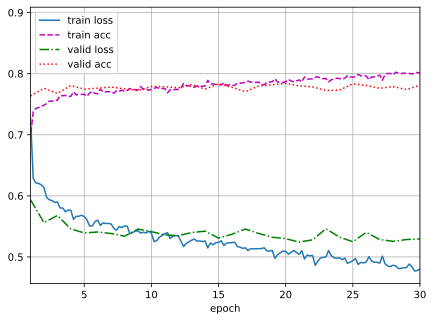

In [11]:
net = MLPs(args.embedding_dim, args.hidden_dim, args.num_class, args.num_aspect, embedding_matrix)
train(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)

In [13]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

test on final epoch -- acc: 77.73, f1-macro: 68.76
test on checkpoints/MLPs-epoch20-val_loss0.52.pt -- acc: 77.46, f1-macro: 68.79


train loss 0.509, train acc 0.785, valid loss 0.562, valid acc 0.756
12552.9 examples/sec on [device(type='cuda', index=1)]


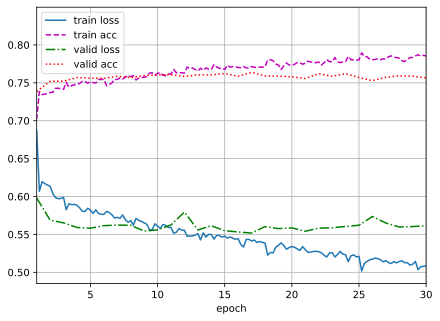

In [7]:
net = MLP(args.embedding_dim, args.hidden_dim, args.num_class, 2, embedding_matrix)
train(net, train_iter, dev_iter, args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)

In [8]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

test on final epoch -- acc: 75.26, f1-macro: 62.43
test on checkpoints/MLP-epoch16-val_loss0.55.pt -- acc: 75.53, f1-macro: 63.83


train loss 0.545, train acc 0.770, valid loss 0.530, valid acc 0.778
10058.8 examples/sec on [device(type='cuda', index=1)]


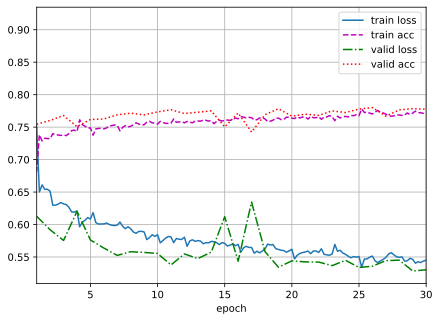

In [9]:
net = MLPv2(args.embedding_dim, args.hidden_dim, args.num_class, 2, embedding_matrix)
train(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)

In [10]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

test on final epoch -- acc: 76.75, f1-macro: 66.29
test on checkpoints/MLPv2-epoch28-val_loss0.53.pt -- acc: 77.48, f1-macro: 69.13


###  5.2 <a name='5.2'></a>RNN
[Back to Table of Contents](#top)

![Illustration of RNN for ABSC](images/LSTM.png)

We implemented RNN for aspect-specific sentimental classification, firstly, we embedded reviews and aspects resepectively and concatedthem. then we put them in the bidirecton LSTM model and train the reviews according to the important information from forward and backward. Finally, get the output dimension by linear layer.
In version 2, I guess position may contain more information so I add position by encoder, but result did not improve, so I tried another version, change the encoder method into embedding. But result is similar with that of version2. I think that itis becaue BiLSTM, could include enough position information by two directional learning.

In [7]:
class RNNV0(nn.Module):
    """ Simple multi-layer perceptron (also called FFN) for all aspects"""

    def __init__(self, input_dim, hidden_dim, output_dim,num_aspects, num_layers, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.output_dim=output_dim
        self.num_aspects = num_aspects
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,bidirectional=True)
        self.decoder = nn.Linear(4*hidden_dim, output_dim)

    def forward(self, input_ids, aspect_id, **kwarg):
        x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_id) #[batch_size, seq_length, hidden_dim]
        x = torch.cat(( aspect_x.unsqueeze(1),x), dim=1) 
        x=x.permute(1,0,2)
      
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(x)#[batch_size, 2*hidden_dim]
            #print(outputs.shape)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
            #print(encoding.shape)
        output = self.decoder(encoding)
            #print(output[i].shape)
        return output # [seq_len, batch_size, output_dim]

class RNNV1(nn.Module):
    """ Simple multi-layer perceptron (also called FFN) for all aspects"""

    def __init__(self, input_dim, hidden_dim, output_dim,num_aspects, num_layers, embedding_matrix,seq_length):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.output_dim=output_dim
        self.num_aspects = num_aspects
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,bidirectional=True)
        self.decoder = nn.Linear(4*hidden_dim, output_dim)
        self.pos_encoder = PositionalEncoding(300, 0.1, seq_length+1)
    def forward(self, input_ids, aspect_id, **kwarg):
      # first dimension of the input required by the LSMN is the time dimension
        x = self.embedding(input_ids) # [seq_length, batch_size, hidden_dim]
        aspect_x = self.embedding(aspect_id)  # [batch_size, hidden_dim]
        x = torch.cat((aspect_x.unsqueeze(1), x), dim=1) # [batch_size,seq_length+1,  300]
        #print(x.shape)
        x = self.pos_encoder(x.permute(1,0,2)) # [seq_length+1, batch_size, 300]
        #print(x.shape)
        #x=x.permute(1,0,2)
        
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(x)#[batch_size, 2*hidden_dim]
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs # [batch_size, output_dim]

class RNNV2(nn.Module):
    """ Simple multi-layer perceptron (also called FFN) for all aspects"""

    def __init__(self, input_dim, hidden_dim, output_dim,num_aspects, num_layers, embedding_matrix,seq_length):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.output_dim=output_dim
        self.num_aspects = num_aspects
        self.encoder1 = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,bidirectional=True)
        self.decoder = nn.Linear(4*hidden_dim, output_dim)
        self.pos_emb_layer = nn.Embedding(seq_length+1,
                                          300,
                                          padding_idx=0)
        self.linear_proj = nn.Sequential(
            nn.Linear(input_dim, 300),
            nn.ReLU()
        )
    def forward(self, input_ids, aspect_id,attention_mask,position_ids, **kwarg):
      # first dimension of the input required by the LSMN is the time dimension
        x = self.embedding(input_ids) # [seq_length, batch_size, hidden_dim]
        aspect_x = self.embedding(aspect_id)  # [batch_size, hidden_dim]
        #print(position_ids.shape)
        pos_emb = self.pos_emb_layer(position_ids.type(torch.long))
        x = self.linear_proj(x) + pos_emb # [batch_size, seq_length, 300]
        x = torch.cat((aspect_x.unsqueeze(1), x), dim=1) # [batch_size, seq_length+1, 300]
        #print(x.shape)
        x=x.permute(1,0,2)
        #aspect_mask = torch.zeros((x.shape[0], 1), dtype=torch.bool, device=x.device) 
        #attention_mask = torch.cat((aspect_mask, attention_mask), dim=1) # [batch_size, seq_length+1]
        self.encoder1.flatten_parameters()
        outputs, _ = self.encoder1(x)#[batch_size, 2*hidden_dim]
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        #print(outputs.shape)
        outs = self.decoder(encoding)
        return outs # [batch_size, output_dim]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        #print(d_model)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

train loss 0.247, train acc 0.899, valid loss 0.714, valid acc 0.776
374.4 examples/sec on [device(type='cuda', index=0)]
test on final epoch -- acc: 77.52, f1-macro: 69.72
test on checkpoints/RNNV0-epoch6-val_loss0.51.pt -- acc: 79.00, f1-macro: 70.29


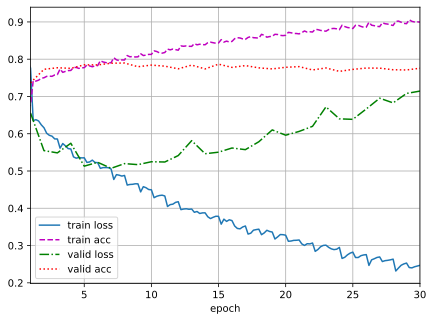

In [8]:
args.lr=1e-4
net = RNNV0(args.embedding_dim, args.hidden_dim, args.num_class, args.num_aspect,2, embedding_matrix)
train(net, train_iter, dev_iter, args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

train loss 0.348, train acc 0.852, valid loss 0.613, valid acc 0.775
372.7 examples/sec on [device(type='cuda', index=0)]
test on final epoch -- acc: 76.71, f1-macro: 67.26
test on checkpoints/RNNV1-epoch6-val_loss0.52.pt -- acc: 77.09, f1-macro: 65.78


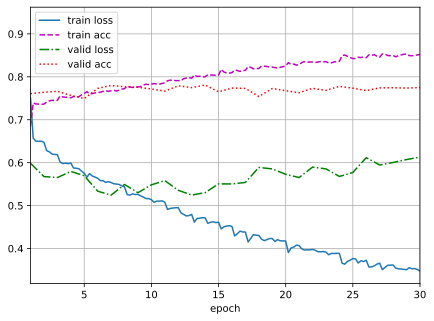

In [9]:
net = RNNV1(args.embedding_dim, args.hidden_dim, args.num_class, args.num_aspect,2, embedding_matrix, args.max_seq_len)
train(net, train_iter, dev_iter, args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

train loss 0.373, train acc 0.844, valid loss 0.595, valid acc 0.770
360.6 examples/sec on [device(type='cuda', index=0)]
test on final epoch -- acc: 77.23, f1-macro: 69.30
test on checkpoints/RNNV2-epoch12-val_loss0.52.pt -- acc: 77.61, f1-macro: 69.40


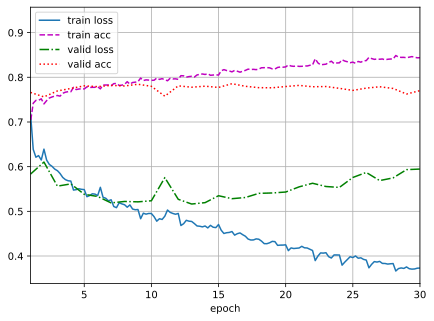

In [10]:
net = RNNV2(args.embedding_dim, args.hidden_dim, args.num_class, args.num_aspect,2, embedding_matrix, args.max_seq_len)
train(net, train_iter, dev_iter, args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

###  5.3 <a name='5.3'></a>TextCNN
[Back to Table of Contents](#top)

![Illustration of TextCNN for ABSC](images/TextCNN.jpg)

For the TextCNN, we use glove to convert review and aspect into word vectors, process them with different operations, and then pass through three convolutional layers respectively. After convolution, the result is passed to the pooling layer. After pooling, concatenating all the scalar pooling outputs as a vector. Then pass the dropout layer to help prevent overfitting. Lastly, transform the concatenated vector into the output categories using the fully connected layer.
We have build two set of models, which represent different pooling method:max pooling and average pooling . And each set contain three models. These three models each have different operations on the input vector. The first one is to directly add the aspect vector to the review tensor to form a 501-length tensor. The second and third are to add or multiply the corresponding value of the aspect vector with the value of the review tensor respectively. These two operations won't change the shape of the input tensor. 

In [9]:
class TextCNNv1(nn.Module):
    def __init__(self,embed_size, kernel_sizes, num_channels,embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 3)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(embed_size, c, k))

    def forward(self, input_ids, aspect_token_id,**kwarg):

        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.cat((input_x, aspect_x.unsqueeze(1)), dim=1) # [batch_size, seq_length+1, hidden_dim]
        x = x.permute(0,2,1)
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(x))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs
class TextCNNv2(nn.Module):
    def __init__(self,embed_size, kernel_sizes, num_channels,embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 3)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(embed_size, c, k))

    def forward(self, input_ids, aspect_token_id,**kwarg):

        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.add(input_x, aspect_x.unsqueeze(1)) # [batch_size, seq_length+1, hidden_dim]
        x = x.permute(0,2,1)
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(x))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

class TextCNNv3(nn.Module):
    def __init__(self,embed_size, kernel_sizes, num_channels,embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 3)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(embed_size, c, k))

    def forward(self, input_ids, aspect_token_id,**kwarg):

        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.mul(input_x, aspect_x.unsqueeze(1)) # [batch_size, seq_length+1, hidden_dim]
        x = x.permute(0,2,1)
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(x))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs
class TextCNNv1_maxpool(nn.Module):
    def __init__(self,embed_size, kernel_sizes, num_channels,embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 3)
        self.pool1 = nn.MaxPool1d(499)
        self.pool2 = nn.MaxPool1d(498)
        self.pool3 = nn.MaxPool1d(497)
        self.pools=[self.pool1,self.pool2,self.pool3]
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(embed_size, c, k))

    def forward(self, input_ids, aspect_token_id,**kwarg):

        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.cat((input_x, aspect_x.unsqueeze(1)), dim=1) # [batch_size, seq_length+1, hidden_dim]
        x = x.permute(0,2,1)
        i=0
        result=[]
        for conv in self.convs:
            ele = torch.squeeze(self.relu(self.pools[i](conv(x))), dim=-1)
            result.append(ele)
            i+=1
        encoding = torch.cat(result,dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs
class TextCNNv2_maxpool(nn.Module):
    def __init__(self,embed_size, kernel_sizes, num_channels,embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 3)
        self.pool1 = nn.MaxPool1d(498)
        self.pool2 = nn.MaxPool1d(497)
        self.pool3 = nn.MaxPool1d(496)
        self.pools=[self.pool1,self.pool2,self.pool3]
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(embed_size, c, k))

    def forward(self, input_ids, aspect_token_id,**kwarg):

        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.add(input_x, aspect_x.unsqueeze(1)) # [batch_size, seq_length+1, hidden_dim]
        x = x.permute(0,2,1)
        i=0
        result=[]
        for conv in self.convs:
            ele = torch.squeeze(self.relu(self.pools[i](conv(x))), dim=-1)
            result.append(ele)
            i+=1
        encoding = torch.cat(result,dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs
class TextCNNv3_maxpool(nn.Module):
    def __init__(self,embed_size, kernel_sizes, num_channels,embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 3)
        self.pool1 = nn.MaxPool1d(498)
        self.pool2 = nn.MaxPool1d(497)
        self.pool3 = nn.MaxPool1d(496)
        self.pools=[self.pool1,self.pool2,self.pool3]
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(embed_size, c, k))

    def forward(self, input_ids, aspect_token_id,**kwarg):

        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.mul(input_x, aspect_x.unsqueeze(1)) # [batch_size, seq_length+1, hidden_dim]
        x = x.permute(0,2,1)
        i=0
        result=[]
        for conv in self.convs:
            ele = torch.squeeze(self.relu(self.pools[i](conv(x))), dim=-1)
            result.append(ele)
            i+=1
        encoding = torch.cat(result,dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

train loss 0.322, train acc 0.860, valid loss 0.527, valid acc 0.789
2509.0 examples/sec on [device(type='cuda', index=0)]
test on final epoch -- acc: 78.61, f1-macro: 70.40
test on checkpoints/TextCNNv1_maxpool-epoch5-val_loss0.50.pt -- acc: 78.59, f1-macro: 69.73


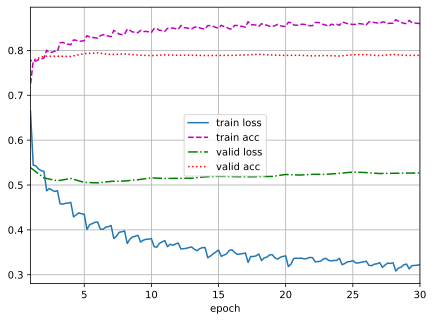

In [11]:
args.lr=1e-4
embed_size=300
kernel_sizes=[3,4,5]
num_channels=[300,300,3]
net = TextCNNv1_maxpool(embed_size,kernel_sizes,num_channels,embedding_matrix)
train(net, train_iter, dev_iter, args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

train loss 0.276, train acc 0.891, valid loss 0.503, valid acc 0.798
5513.1 examples/sec on [device(type='cuda', index=0)]
test on final epoch -- acc: 79.79, f1-macro: 71.74
test on checkpoints/TextCNNv2_maxpool-epoch11-val_loss0.49.pt -- acc: 79.61, f1-macro: 71.87


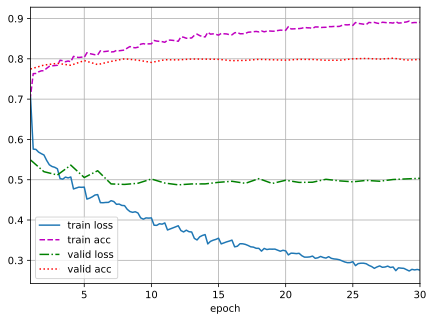

In [12]:
net = TextCNNv2_maxpool(embed_size,kernel_sizes,num_channels,embedding_matrix)
train(net, train_iter, dev_iter, args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

train loss 0.242, train acc 0.922, valid loss 0.517, valid acc 0.792
5497.2 examples/sec on [device(type='cuda', index=0)]
test on final epoch -- acc: 78.32, f1-macro: 69.19
test on checkpoints/TextCNNv3_maxpool-epoch18-val_loss0.51.pt -- acc: 78.52, f1-macro: 69.96


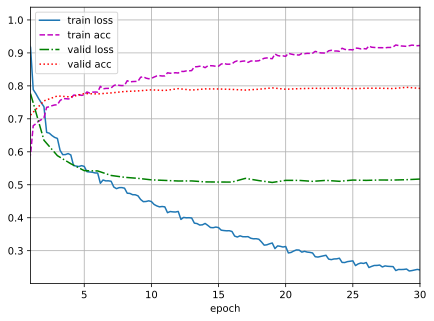

In [13]:
net = TextCNNv3_maxpool(embed_size,kernel_sizes,num_channels,embedding_matrix)
train(net, train_iter, dev_iter, args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

train loss 0.681, train acc 0.721, valid loss 0.637, valid acc 0.753
4179.8 examples/sec on [device(type='cuda', index=0)]
test on final epoch -- acc: 73.10, f1-macro: 61.53
test on checkpoints/TextCNNv2-epoch28-val_loss0.63.pt -- acc: 72.13, f1-macro: 59.29


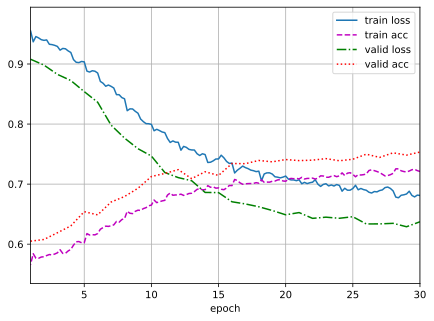

In [14]:
net = TextCNNv2(embed_size,kernel_sizes,num_channels,embedding_matrix)
train(net, train_iter, dev_iter, args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

As we can see from the results of the model, the max pooling group is much more better than the average pooling one. I think when we use average pooling, because the content is up to 500 words, after averaging, some insignificant words affect the features while max pooling helps to pick on the most salient features well. And this also corresponds to the 1-max pooling method used in the textcnn paper. According to the paper, The idea is to capture the most important feature—one with the highest value—for each feature map. This pooling scheme naturally deals with variable sentence lengths.
On the operations of the input tensor, we can see that V1 has the worst effect and V2 has the best effect. Adding the corresponding value of the aspect vector with the value of the review tensor seems to be a better feature for the model.

###  5.4 <a name='5.4'></a>Transformer
[Back to Table of Contents](#top)

![Architecture of the Transformer Encoder for ABSC](images/Transformer.png)
<!-- <img src="images/Transformer.png" width="800"> -->

Here, we adopt transformer to this project. We use encoder only because this is not generative task and encoder is enough for doing classification. As you can see from the results, transformer can only achieve near accuracy as MLP, works worse than textCNN or RNN. So, we conduct two experiments v1 and v2 to explore the reason. We use pretrained glove vector and randomly initialized but learnable embeddings for the whole corpus. We achieve similar accuracy. the result suggest the glove embeddings doesn't contribute to transformer architecture. the reason is that we need additional linear layer to project the hidden size of glove 300 to transformers' hidden size, 512. This process decrease the power of pretrained glove embeddings. 

In [22]:
class TransformerEncoderV0(nn.Module):
    """ Transformer encoder"""
    def __init__(self, input_dim, output_dim, num_layers, embedding_matrix, seq_length, drop=0.1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.pos_encoder = PositionalEncoding(512, 0.1, seq_length+1)
        self.linear_proj = nn.Linear(input_dim, 512)
        
        trans_encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=8,
            dim_feedforward=2048,
            dropout=drop,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(trans_encoder_layer, num_layers=num_layers)
        
        self.clf = nn.Sequential(
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Dropout(p=drop),
            nn.Linear(512, output_dim),
        )

    def forward(self, input_ids, aspect_token_id, attention_mask, **kwarg):
        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.cat((aspect_x.unsqueeze(1), input_x), dim=1) # [batch_size, seq_length+1, hidden_dim]
        x = self.linear_proj(x) # [batch_size, seq_length+1, 512]
        x = self.pos_encoder(x.permute(1,0,2)) # [seq_length+1, batch_size, 512]
        x = x.permute(1,0,2) # [batch_size, seq_length+1, 512]
        aspect_mask = torch.zeros((x.shape[0], 1), dtype=torch.bool, device=x.device) # [batch_size, seq_length]
        attention_mask = torch.cat((aspect_mask, attention_mask), dim=1) # [batch_size, seq_length+1]
        x = self.encoder(x, src_key_padding_mask=attention_mask) # [batch_size, seq_length+1, 512]
        logits = self.clf(x.mean(dim=1)) # [batch_size, output_dim]
        return logits
    
class TransformerEncoderV1(nn.Module):
    """ Transformer encoder"""
    def __init__(self, input_dim, output_dim, num_layers, embedding_matrix, seq_length, num_aspect, drop=0.1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.aspect_embedding = nn.Embedding(num_aspect, 512)
        self.pos_encoder = PositionalEncoding(512, 0.1, seq_length+1)
        self.linear_proj = nn.Linear(input_dim, 512)
        
        trans_encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=8,
            dim_feedforward=2048,
            dropout=drop,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(trans_encoder_layer, num_layers=num_layers)
        
        self.clf = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(p=drop),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Dropout(p=drop),
            nn.Linear(1024, output_dim),
        )

    def forward(self, input_ids, aspect_id, attention_mask, **kwarg):
        x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        x = self.linear_proj(x) # [batch_size, seq_length, 512]
        aspect_x = self.aspect_embedding(aspect_id)  # [batch_size, 512]
        x = torch.cat((aspect_x.unsqueeze(1), x), dim=1) # [batch_size, seq_length+1, 512]
        x = self.pos_encoder(x.permute(1,0,2)) # [seq_length+1, batch_size, 512]
        x = x.permute(1,0,2) # [batch_size, seq_length+1, 512]
        aspect_mask = torch.zeros((x.shape[0], 1), dtype=torch.bool, device=x.device) # [batch_size, seq_length]
        attention_mask = torch.cat((aspect_mask, attention_mask), dim=1) # [batch_size, seq_length+1]
        x = self.encoder(x, src_key_padding_mask=attention_mask) # [batch_size, seq_length+1, 512]
        logits = self.clf(x[:,0,:])
        return logits # [batch_size, output_dim]

class TransformerEncoderV2(nn.Module):
    """ Transformer encoder"""
    def __init__(self, input_dim, output_dim, num_layers, embedding_matrix, seq_length, num_aspect, drop=0.1):
        super().__init__()
        self.embedding = nn.Embedding(embedding_matrix.shape[0], 512)
        self.aspect_embedding = nn.Embedding(num_aspect, 512)
        self.pos_encoder = PositionalEncoding(512, 0.1, seq_length+1)
        
        trans_encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=8,
            dim_feedforward=2048,
            dropout=drop,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(trans_encoder_layer, num_layers=num_layers)
        
        self.clf = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(p=drop),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Dropout(p=drop),
            nn.Linear(1024, output_dim),
        )

    def forward(self, input_ids, aspect_id, attention_mask, **kwarg):
        x = self.embedding(input_ids) # [batch_size, seq_length, 512]
        aspect_x = self.aspect_embedding(aspect_id)  # [batch_size, 512]
        x = torch.cat((aspect_x.unsqueeze(1), x), dim=1) # [batch_size, seq_length+1, 512]
        x = self.pos_encoder(x.permute(1,0,2)) # [seq_length+1, batch_size, 512]
        x = x.permute(1,0,2) # [batch_size, seq_length+1, 512]
        aspect_mask = torch.zeros((x.shape[0], 1), dtype=torch.bool, device=x.device) # [batch_size, seq_length]
        attention_mask = torch.cat((aspect_mask, attention_mask), dim=1) # [batch_size, seq_length+1]
        x = self.encoder(x, src_key_padding_mask=attention_mask) # [batch_size, seq_length+1, 512]
        logits = self.clf(x[:,0,:])
        return logits # [batch_size, output_dim]
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class TransformerEncoderV3(nn.Module):
    """ Transformer encoder"""
    def __init__(self, input_dim, output_dim, num_layers, embedding_matrix, seq_length, num_aspect, drop=0.1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.aspect_embedding = nn.Embedding(num_aspect, 512)
        self.pos_emb_layer = nn.Embedding(seq_length+1,
                                          512,
                                          padding_idx=0)
        self.linear_proj = nn.Linear(input_dim, 512)
        
        trans_encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=8,
            dim_feedforward=2048,
            dropout=drop,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(trans_encoder_layer, num_layers=num_layers)
        
        self.clf = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=drop),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Dropout(p=drop),
            nn.Linear(128, output_dim),
        )

    def forward(self, input_ids, aspect_id, attention_mask, position_ids, **kwarg):
        x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.aspect_embedding(aspect_id)  # [batch_size, hidden_dim]
        pos_emb = self.pos_emb_layer(position_ids.type(torch.long))
        x = self.linear_proj(x) + pos_emb # [batch_size, seq_length, 512]
        x = torch.cat((aspect_x.unsqueeze(1), x), dim=1) # [batch_size, seq_length+1, 512]
        aspect_mask = torch.zeros((x.shape[0], 1), dtype=torch.bool, device=x.device) 
        attention_mask = torch.cat((aspect_mask, attention_mask), dim=1) # [batch_size, seq_length+1]
        x = self.encoder(x, src_key_padding_mask=attention_mask) # [batch_size, seq_length+1, 512]
        logits = self.clf(x[:,0,:]) # [batch_size, output_dim]
        return logits

train loss 0.472, train acc 0.806, valid loss 0.593, valid acc 0.779
120.3 examples/sec on [device(type='cuda', index=0)]


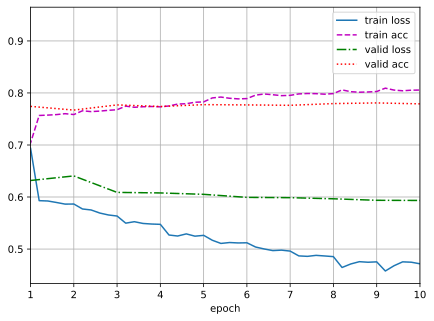

In [16]:
args.lr = 5e-5
args.num_epochs=10
net = TransformerEncoderV0(args.embedding_dim, args.num_class, 6, embedding_matrix, args.max_seq_len, 0.3)
train_transformer(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.num_warmup_steps, devices)

In [17]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

test on final epoch -- acc: 78.11, f1-macro: 69.57
test on checkpoints/TransformerEncoderV0-epoch9-val_loss0.59.pt -- acc: 78.11, f1-macro: 69.57


train loss 0.469, train acc 0.806, valid loss 0.534, valid acc 0.783
177.9 examples/sec on [device(type='cuda', index=0)]


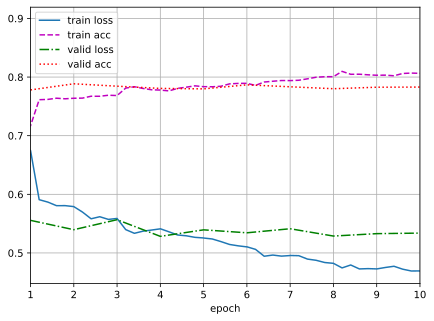

In [18]:
args.lr = 5e-5
net = TransformerEncoderV1(args.embedding_dim, args.num_class, 6, embedding_matrix, args.max_seq_len, args.num_aspect, 0.3)
train_transformer(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.num_warmup_steps, devices)

In [19]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

test on final epoch -- acc: 78.00, f1-macro: 69.71
test on checkpoints/TransformerEncoderV1-epoch3-val_loss0.53.pt -- acc: 77.86, f1-macro: 69.74


train loss 0.393, train acc 0.836, valid loss 0.625, valid acc 0.772
170.7 examples/sec on [device(type='cuda', index=0)]


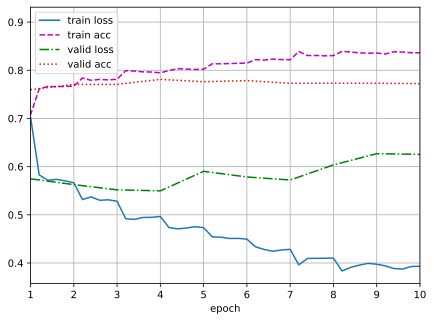

In [21]:
net = TransformerEncoderV2(args.embedding_dim, args.num_class, 6, embedding_matrix, args.max_seq_len, args.num_aspect, 0.3)
train_transformer(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.num_warmup_steps, devices)

In [23]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

test on final epoch -- acc: 77.11, f1-macro: 69.43
test on checkpoints/TransformerEncoderV2-epoch3-val_loss0.55.pt -- acc: 76.62, f1-macro: 68.46


###  5.5 <a name='5.5'></a>BERT
[Back to Table of Contents](#top)

We introduce a much deeper transformer, pre-trained BERT. According to original bert paper, it actually works for sentence pair classification. Thanks to its pretraining strategy, next sentence prediction, when we input as the format we used here, the model will tried to build the relation between service aspect and the corresponding text.

Reference:  
[Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.

<!-- ![Architecture of the BERT for ABSC](images/Bert.png) -->
<img src="images/Bert.png" width="800">

In [18]:
from transformers import BertTokenizer, BertModel
class ABSCDatasetForBERT(Dataset):
    """Build dataset and convert examples to features"""
    def __init__(self, name, examples):
        self.name = name
        self.examples = examples
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.convert_data_to_features()
    
    def convert_data_to_features(self):
        """convert examples to features"""
        label_map = {0: 0, 1: 1, 2: 2}
        aspect_map = {"value":0, "location":1, "service":2, "room":3, "clean":4, "sleep":5}

        output = []
        for (i, example) in enumerate(tqdm(self.examples)):
            feature = {}
            inputs = self.tokenizer.encode_plus(
                text = example.aspect,
                text_pair = example.text,
                padding = 'max_length',
                max_length = 500,
                truncation = 'only_second',
                return_token_type_ids = True,
                return_tensors='pt',
            )
            
            input_ids = inputs["input_ids"][0]
            token_type_ids  = inputs["token_type_ids"][0]
            attention_mask = inputs["attention_mask"][0]
            aspect_id = aspect_map[example.aspect]
            label_id = label_map[example.label]
            feature = {
                "input_ids": input_ids,
                "token_type_ids": token_type_ids,
                "attention_mask": attention_mask,
                "aspect_id": aspect_id,
                "label_id": label_id
            }
            output += [feature]
        self.data = output
        
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

print("Processing the Dataset")
data_dir="dataset"
data_name = "TripAdvisor"
datset_path = os.path.join(data_dir, data_name)
processor = ABSCProcessor(data_dir, data_name)
aspects = processor.get_aspects()
num_classes = len(processor.get_labels())
train_examples = processor.get_examples("train")
dev_examples = processor.get_examples("dev")
test_examples = processor.get_examples("test")
train_data = ABSCDatasetForBERT(data_name, train_examples)
dev_data = ABSCDatasetForBERT(data_name, dev_examples)
test_data = ABSCDatasetForBERT(data_name, test_examples)

Processing the Dataset


  0%|          | 0/35611 [00:00<?, ?it/s]

  0%|          | 0/3929 [00:00<?, ?it/s]

  0%|          | 0/4409 [00:00<?, ?it/s]

In [28]:
class Bert(nn.Module):
    """ Transformer encoder"""
    def __init__(self, output_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.d_model = self.bert.config.hidden_size
        self.clf = nn.Sequential(
            nn.Linear(self.d_model, self.d_model),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            nn.Linear(self.d_model, output_dim),
        )

    def forward(self, input_ids, attention_mask, token_type_ids, **kwarg):
        outputs = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask, 
            token_type_ids = token_type_ids,
        ).last_hidden_state
        logits = self.clf(outputs[:,0,:])
        return logits

In [ ]:
args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=16
args.monitor = 'accuracy'
train_iter = DataLoader(dataset=train_data, batch_size = args.batch_size, shuffle=True)
dev_iter = DataLoader(dataset=dev_data, batch_size = args.batch_size, shuffle=False)
test_iter = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

train loss 0.126, train acc 0.954, valid loss 0.644, valid acc 0.819
46.0 examples/sec on [device(type='cuda', index=0)]


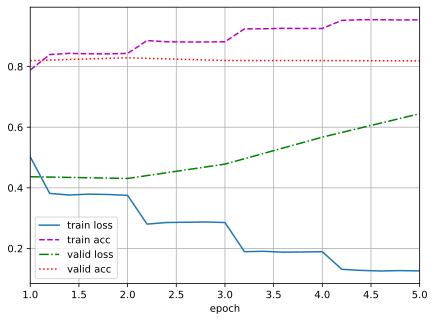

In [32]:
net = Bert(args.num_class)
train_transformer(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.num_warmup_steps, devices)

In [33]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

test on final epoch -- acc: 82.47, f1-macro: 76.47
test on checkpoints/Bert-epoch1-val_acc0.83.pt -- acc: 82.79, f1-macro: 76.09


#### Note
For BERT model and transformer-based model, we introduce cosine_schedule_with_warmup from [Huggingface Optimization](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules) during training. Warm up steps is a parameter which is used to lower the learning rate in order to reduce the impact of deviating the model from learning on sudden new data set exposure. By default, number of warm up steps is 0, here we set it as 200. The idea is that we hope the model make bigger steps when the objective is probably not near the minima. But as we are approaching the minima, we make smaller steps to converge to it.

Why we need warmup for traning transformer? In some cases initializing the parameters is not sufficient to guarantee a good solution. This is particularly a problem for some advanced network designs that may lead to unstable optimization problems. We could address this by choosing a sufficiently small learning rate to prevent divergence in the beginning. Unfortunately this means that progress is slow. Conversely, a large learning rate initially leads to divergence. A rather simple fix for this dilemma is to use a warmup period during which the learning rate increases to its initial maximum and to cool down the rate until the end of the optimization process.[Huang et al., 2020](https://www.cs.toronto.edu/~mvolkovs/ICML2020_tfixup.pdf) found that without warm-up, the gradients vanish very quickly, and the Adam updates also rapidly become much smaller. Diminishing gradients at lower layers in the transformer model without warm-up have also been observed by [Liu et al., 2020](https://arxiv.org/abs/2004.08249).

Why cosine scheduler?
A rather perplexing heuristic was proposed by [Loshchilov and Hutter (2016)](https://arxiv.org/abs/1608.03983). It relies on the observation that we might not want to decrease the learning rate too drastically in the beginning and moreover, that we might want to “refine” the solution in the end using a very small learning rate. This results in a cosine-like schedule with the following functional form for learning rates in the range

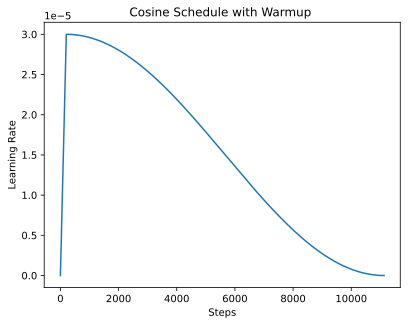

In [37]:
plt.figure()
plt.plot(np.arange(0, args.num_epochs*len(train_iter), 1),args.learning_rates)
plt.title('Cosine Schedule with Warmup ')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.show()

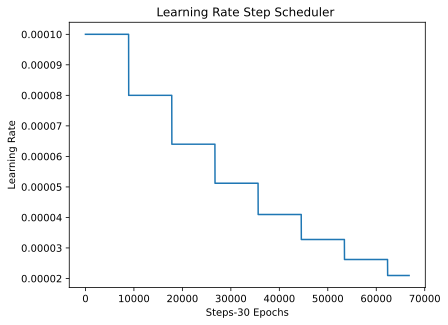

In [17]:
plt.figure()
plt.plot(np.arange(0, args.num_epochs*len(train_iter), 1),args.learning_rates)
plt.title('Learning Rate Step Scheduler ')
plt.xlabel('Steps-30 Epochs')
plt.ylabel('Learning Rate')
plt.show()

###  5.6 <a name='5.6'></a>Aspect-specific Sentiment Aggregation Block
[Back to Table of Contents](#top)

<!-- ![Illustration of Aspect-specific Sentiment Aggregation](images/ASA.png) -->
<img src="images/ASA.png" width="500">

Here, we proposed an aspect-specific attentive pooling based on the attention mechanism mentioned in the lecture. We first initialized embeddings for six aspects by calling nn.embedding() and aggregate all input tokens
$[e_1,e_2,...,e_N]$ and obtain the output $l_i$ as follows:
 \begin{equation}
  \text{Output}_j = \sum_{i=1}^{N} \alpha_i e_i
\end{equation}
where $\alpha_i$ is derived based on the attention mechanism:
\begin{equation}
    \alpha_i = \frac{\exp( q^T f(e_i))}{  \sum_{i^{'}=1}^{N} \exp ( q^T f(e_{i^{'}})}
\end{equation}
where $q^T$ is the aspect query, $f(\cdot)$ consists of a linear projection followed by the activation function tanh.

In [19]:
class AttentiveAggregation(nn.Module):
    """ Aggregation based on a single aspect query """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.k_proj = self.clf = nn.Sequential(
            nn.Linear(self.dim, self.dim),
            nn.Tanh(),
        )

    def forward(self, q, v, mask):
        '''
        Args:
            q: [batch_size, dim],
            v: [batch_size, seq_len, dim]
            mask: [batch_size, seq_len]
        Return:   
            values: [batch_size, dim]
        '''
        k = self.k_proj(v) # [batch_size, seq, dim]
        attn_logits = torch.matmul(k, q.unsqueeze(-1)) # [batch_size, seq, dim] @ [batch_size, dim, 1] = [batch_size, seq, 1]
        attn_logits = attn_logits.squeeze(-1)
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask == 0, -np.inf)
        attention = F.softmax(attn_logits, dim=-1) # [batch_size, seq]
        values = torch.matmul(attention.unsqueeze(1), v) # [batch_size,1, seq] @ [batch_size, seq, dim] = [batch_size,1, dim]
        return values.squeeze(1)
    
class BertForABSC(nn.Module):
    """ Transformer encoder"""
    def __init__(self, output_dim, num_aspect, num_aspect_query=None):
        super().__init__()
        self.num_aspect_query = num_aspect_query
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.d_model = self.bert.config.hidden_size
        self.aspect_embeddings = nn.ModuleList()
        for _ in range(self.num_aspect_query):
            self.aspect_embeddings.append(nn.Embedding(num_aspect, self.d_model))
        self.agg = AttentiveAggregation(self.d_model)
        if (not self.num_aspect_query) or self.num_aspect_query == 1:
            self.clf = nn.Sequential(
                nn.Linear(self.d_model, self.d_model),
                nn.Tanh(),
                nn.Dropout(p=0.1),
                nn.Linear(self.d_model, output_dim),
            )
        else:
            self.clf = nn.Sequential(
                nn.Linear(self.d_model*self.num_aspect_query, self.d_model),
                nn.ReLU(),
                nn.Dropout(p=0.1),
                nn.Linear(self.d_model, self.d_model),
                nn.Tanh(),
                nn.Dropout(p=0.1),
                nn.Linear(self.d_model, output_dim),
            )

    def forward(self, input_ids, attention_mask, token_type_ids, aspect_id, **kwarg):
        outputs = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask, 
            token_type_ids = token_type_ids,
        ).last_hidden_state
        doc_emb = []
        for aspect_embdding in self.aspect_embeddings:
            aspect_queries = aspect_embdding(aspect_id) # [batch_size, dim]
            doc_emb.append(self.agg(aspect_queries, outputs, attention_mask))
        outputs = torch.cat(doc_emb, dim=-1) # [batch_size, dim*self.num_aspect_query]
        logits = self.clf(outputs)
        return logits

In [20]:
args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=16
args.num_warmup_steps = 200
args.monitor = 'accuracy'
train_iter = DataLoader(dataset=train_data, batch_size = args.batch_size, shuffle=True, num_workers=8, prefetch_factor=4)
dev_iter = DataLoader(dataset=dev_data, batch_size = args.batch_size, shuffle=False, num_workers=8, prefetch_factor=4)
test_iter = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

train loss 0.228, train acc 0.912, valid loss 0.495, valid acc 0.819
45.4 examples/sec on [device(type='cuda', index=0)]


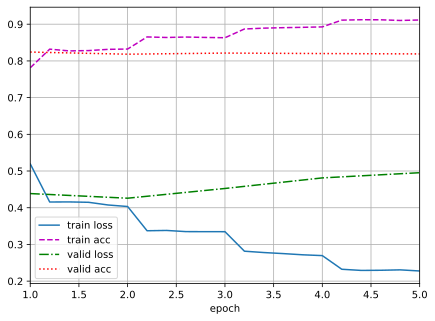

In [31]:
net = BertForABSC(args.num_class, args.num_aspect, 1)
train_transformer(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.num_warmup_steps, devices)

In [32]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

test on final epoch -- acc: 82.63, f1-macro: 76.67
test on checkpoints/BertForABSC-epoch0-val_acc0.82.pt -- acc: 81.13, f1-macro: 72.92


train loss 0.233, train acc 0.907, valid loss 0.500, valid acc 0.825
45.3 examples/sec on [device(type='cuda', index=0)]


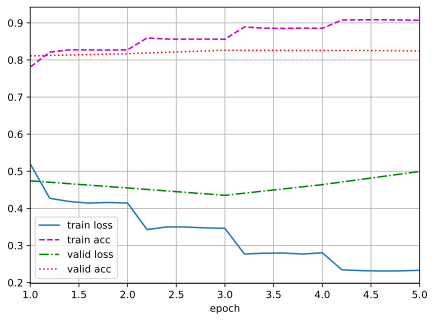

In [9]:
# increase the number of aspect queries to 2
net = BertForABSC(args.num_class, args.num_aspect, 2)
train_transformer(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.num_warmup_steps, devices)

In [10]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

test on final epoch -- acc: 82.67, f1-macro: 76.49
test on checkpoints/BertForABSC-epoch2-val_acc0.83.pt -- acc: 82.65, f1-macro: 76.51


train loss 0.222, train acc 0.915, valid loss 0.495, valid acc 0.827
45.0 examples/sec on [device(type='cuda', index=0)]


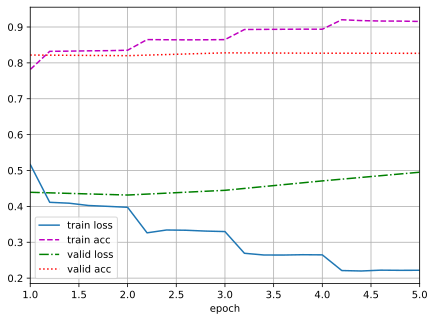

In [29]:
# increase the number of aspect queries to 3
args.lr=2e-5
net = BertForABSC(args.num_class, args.num_aspect, 3)
train_transformer(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.num_warmup_steps, devices)

In [30]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output", device=devices[0])

test on final epoch -- acc: 83.17, f1-macro: 77.33
test on checkpoints/BertForABSC-epoch2-val_acc0.83.pt -- acc: 82.83, f1-macro: 77.10


train loss 0.207, train acc 0.920, valid loss 0.501, valid acc 0.829
44.7 examples/sec on [device(type='cuda', index=0)]


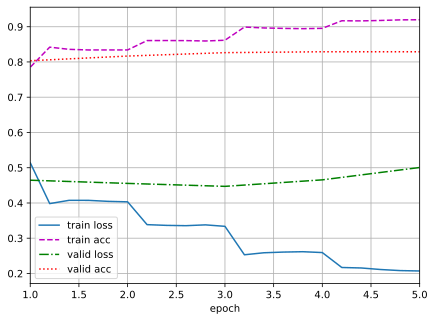

In [23]:
# increase the number of aspect queries to 4
net = BertForABSC(args.num_class, args.num_aspect, 4)
train_transformer(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.num_warmup_steps, devices)

In [24]:
test(net, test_iter, "output", device=devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, "output" , device=devices[0])

test on final epoch -- acc: 82.56, f1-macro: 76.81
test on checkpoints/BertForABSC-epoch3-val_acc0.83.pt -- acc: 82.44, f1-macro: 76.43


##  6. <a name='6'></a>Results
[Back to Table of Contents](#top)

In [13]:
def show_acc_f1(dfs, names):
    output = collections.defaultdict(list)
    output['Model'] = names
    for i, df in enumerate(dfs):
        output['Acc'].append(df[names[i]+'_Acc'][0])
        output['F1'].append(df[names[i]+'_F1'][0])
    return pd.DataFrame(output)

In [19]:
aspects = ["value", "location", "service", "rooms", "cleanliness", "sleep quality"]
model_names = ["MLPs", "MLP", "MLPv2"]
df_mlps = read_and_calculate(aspects, ["./output/MLPs_predictions.json"], model_names[0])
df_mlp = read_and_calculate(aspects, ["./output/MLP_predictions.json"], model_names[1])
df_mlpv2 = read_and_calculate(aspects, ["./output/MLPv2_predictions.json"], model_names[2])
show_acc_f1([df_mlps, df_mlp, df_mlpv2], model_names)

,Model,Acc,F1
0,MLPs,0.774552,0.687900
1,MLP,0.755273,0.638317
2,MLPv2,0.774779,0.691272


In [14]:
model_names = ["RNNV0", "RNNV1", "RNNV2"]
df_rnn0 = read_and_calculate(aspects, ["./output/RNNV0_predictions.json"], model_names[0])
df_rnn1 = read_and_calculate(aspects, ["./output/RNNV1_predictions.json"], model_names[1])
df_rnn2 = read_and_calculate(aspects, ["./output/RNNV2_predictions.json"], model_names[2])
show_acc_f1([df_rnn0, df_rnn1, df_rnn2], model_names)

,Model,Acc,F1
0,RNNV0,0.789975,0.702917
1,RNNV1,0.770923,0.657805
2,RNNV2,0.776140,0.694049


In [15]:
model_names = ["TextCNNv1_max", "TextCNNv2_max", "TextCNNv3_max", "TextCNNv2_mean"]
df_cnn1 = read_and_calculate(aspects, ["./output/TextCNNv1_maxpool_predictions.json"], model_names[0])
df_cnn2 = read_and_calculate(aspects, ["./output/TextCNNv2_maxpool_predictions.json"], model_names[1])
df_cnn3 = read_and_calculate(aspects, ["./output/TextCNNv3_maxpool_predictions.json"], model_names[2])
df_cnn4 = read_and_calculate(aspects, ["./output/TextCNNv2_predictions.json"], model_names[3])
show_acc_f1([df_cnn1, df_cnn2, df_cnn3, df_cnn4], model_names)

,Model,Acc,F1
0,TextCNNv1_max,0.785892,0.697346
1,TextCNNv2_max,0.796099,0.718705
2,TextCNNv3_max,0.785212,0.699641
3,TextCNNv2_mean,0.721252,0.592865


In [16]:
model_names = ["TransEncV0", "TransEncV1", "TransEncV2"]
df_t0 = read_and_calculate(aspects, ["./output/TransformerEncoderV0_predictions.json"], model_names[0])
df_t1 = read_and_calculate(aspects, ["./output/TransformerEncoderV1_predictions.json"], model_names[1])
df_t2 = read_and_calculate(aspects, ["./output/TransformerEncoderV2_predictions.json"], model_names[2])
show_acc_f1([df_t0, df_t1, df_t2], model_names)

,Model,Acc,F1
0,TransEncV0,0.781130,0.695687
1,TransEncV1,0.778635,0.697432
2,TransEncV2,0.766160,0.684584


In [17]:
model_names = ["BERT", "BertForABSC-1", "BertForABSC-2", "BertForABSC-3", "BertForABSC-4"]
df_b0 = read_and_calculate(aspects, ["./output/Bert_predictions.json"], model_names[0])
df_b1 = read_and_calculate(aspects, ["./output/BertForABSC_predictions.json"], model_names[1])
df_b2 = read_and_calculate(aspects, ["./output/BertForABSC_predictions2.json"], model_names[2])
df_b3 = read_and_calculate(aspects, ["./output/BertForABSC_predictions3.json"], model_names[3])
df_b4 = read_and_calculate(aspects, ["./output/BertForABSC_predictions4.json"], model_names[4])
show_acc_f1([df_b0, df_b1, df_b2, df_b3, df_b4], model_names)

,Model,Acc,F1
0,BERT,0.827852,0.760928
1,BertForABSC-1,0.824677,0.761309
2,BertForABSC-2,0.826491,0.765051
3,BertForABSC-3,0.833976,0.775235
4,BertForABSC-4,0.824450,0.764307


In [20]:
cols = ["Aspects", "MLP", "RNN", "TextCNN", "Transformer", "BERT", "BertForABSC"]
df_acc = pd.concat([df_mlpv2["Aspects"], df_mlpv2["MLPv2_Acc"], df_rnn0["RNNV0_Acc"], df_cnn2["TextCNNv2_max_Acc"],
                  df_t0["TransEncV0_Acc"], df_b0["BERT_Acc"], df_b3["BertForABSC-3_Acc"]], axis=1)
df_acc.columns = cols
df_acc

,Aspects,MLP,RNN,TextCNN,Transformer,BERT,BertForABSC
0,ALL,0.774779,0.789975,0.796099,0.781130,0.827852,0.833976
1,VALUE,0.766520,0.792952,0.800294,0.770925,0.829662,0.829662
2,LOCATION,0.794906,0.786863,0.808311,0.794906,0.825737,0.827078
3,SERVICE,0.791624,0.807967,0.812053,0.794688,0.849847,0.855975
4,ROOMS,0.778748,0.797671,0.806405,0.783115,0.825328,0.835517
5,CLEANLINESS,0.742857,0.764286,0.760000,0.765714,0.805714,0.825714
6,SLEEP QUALITY,0.764610,0.782468,0.780844,0.769481,0.821429,0.819805


<Figure size 3000x3000 with 0 Axes>

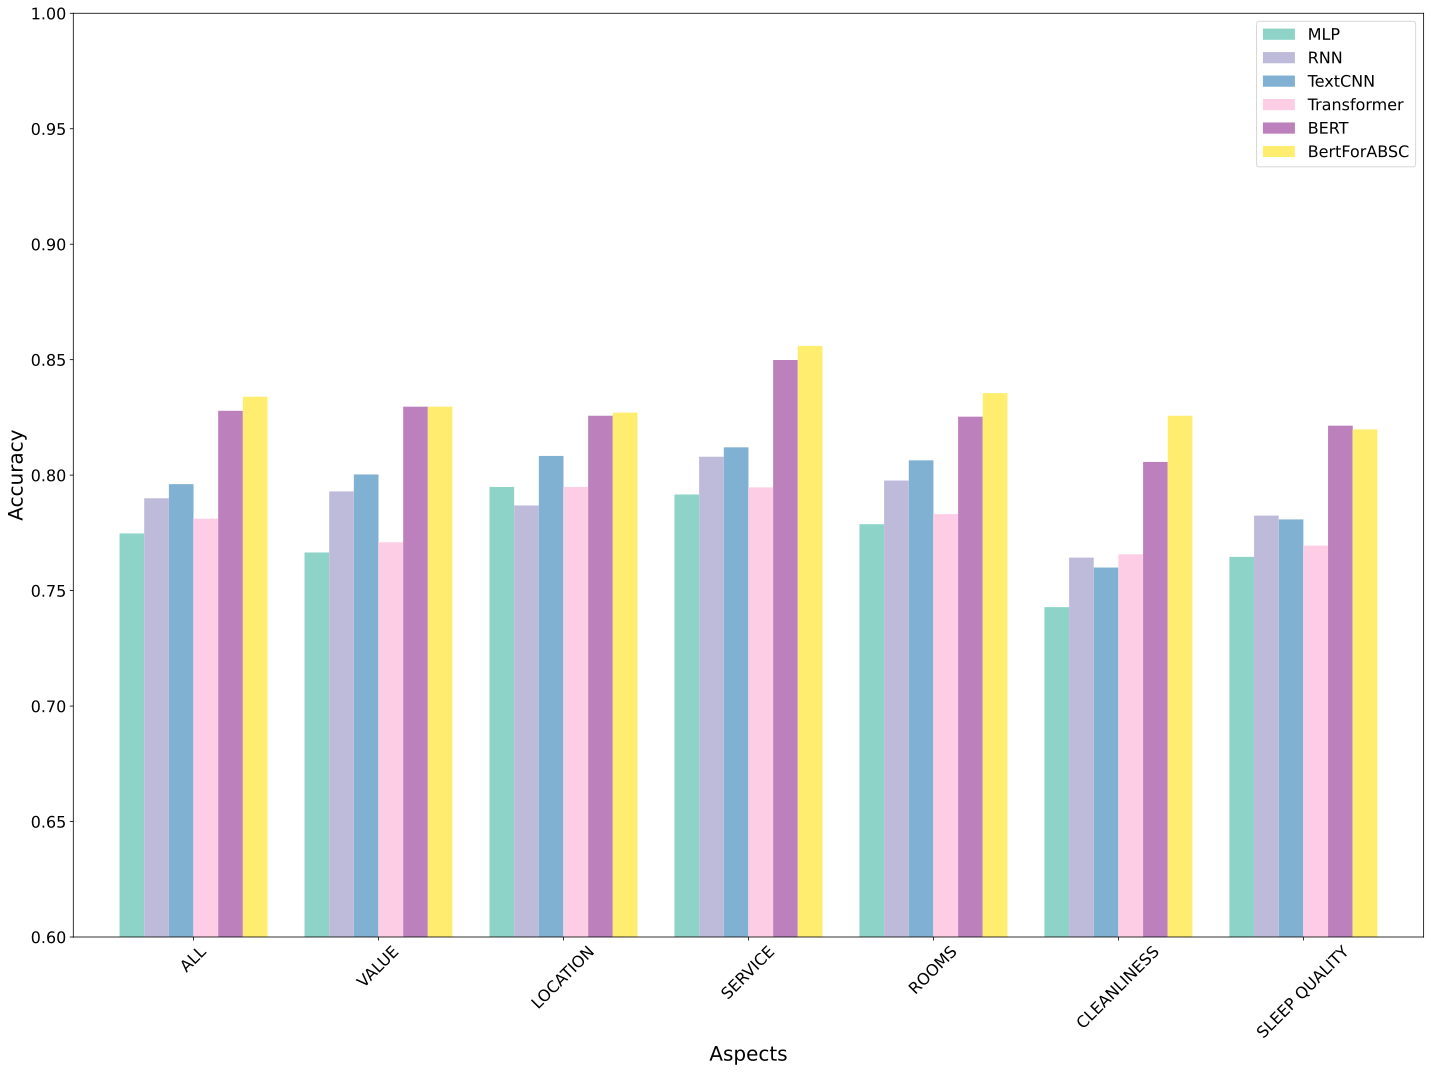

In [139]:
plt.figure(figsize=(30,30))
df_acc.plot(x="Aspects", y=cols[1:], kind="bar", figsize=(20,15), ylim=(0.6,1), width=0.8, colormap=cmap[78])
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.xlabel('Aspects', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(labels=cols[1:], loc="best", prop={'size': 16}) #fontsize=14) 
plt.tight_layout()
plt.savefig("images/Results_Acc_aspects.png", dpi=600)
plt.show()
cnt+=1

##  7. <a name='7'></a>Conclusion & Future Development
[Back to Table of Contents](#top)

From the results, we can se that BERT outperforms previous models due to pretraining. Inspired the attention mechanism mentioned in the lecture, we introduced an aspect-specific aggregation block to further increase the performance. Actually, our proposed aggregation block is still not stable because the embedding weights are randomly initialize and trained during the fine-tuning. Different input sequence can result in different learning features for different aspects. Generally, if we increase the number of aspect queries, the model performance would increase. If the number of queries are too many (larger than 4), the model accuracy decreases, since we don't need so many vectors to represent a aspect and the redundant vectors may learn noise.

Based on the experiments, BERT achieve the best accuracy/F1 in our baselines. We also found that BERT actually overfit the whole dataset very quickly. It makes sense because BERT has already pre-trained on massive corpora. 

It's hard to give a strict reason why BERT persforms better than BiLSTM, textCNN, because BERT actually befinit from a lot of factors, like very deep networks, large corpus pretraining and multi-head attention, etc. So, we tried to explain it through its funcdamental self-attention mechanism and its pre-training representations. Here, we compare various features of self-attention layers to the recurrent and convolutional layers commonly used for mapping one variable-length sequence of symbol representations $(x_1, ..., x_n)$ to another sequence of equal length $(z_1, ..., z_n)$, with $x_i, z_i \in \mathbb{R}^d $, such as a hidden layer in a typical sequence transduction encoder or decoder. Specifically, we set $n$ as 500 and the value of hidden size $h$ as 300, 512, 768 for non-transformer-based models, TransformerEncoder, BERT, respectively). According to [1], one of the most important advantages is the total computational complexity per layer. Another is the amount of computation that can be parallelized, as measured by the minimum number of sequential operations required.

| Layer Type   |     Complexity per Layer     | Sequential Operations |
|----------|:-------------:|:-------------:|
| Self-Attention |  $O(n^2 \cdot d)$ | $O(1)$ |
| Recurrent |    $O(n \cdot d^2)$   |   $O(n)$ |
| Convolutional | $O(k \cdot n \cdot d^2)$ |   $O(1)$ |

where $n$ is the sequence length, $d$ is the representation dimension, $k$ is the kernel size of convolutions.

In table above, a self-attention layer connects all positions with a constant number, $O(1)$ ,of sequentially executed operations, whereas a recurrent layer requires $O(n)$ sequential operations. In terms of computational complexity, self-attention layers are faster than recurrent layers when the sequence length $n$ is smaller than the representation dimensionality $d$, which is most often the case with sentence representations used by state-of-the-art models. But in our project, we deal with text input with much longer length, causing the self-attention requiring more computational cost. To improve it, we consider introduce sparse attention mechanism or other hierarchical architecture in the future [2].

On the other hand, BERT model benefits from:  
- Context-dependent. Unlike previous representations obtained by skip-gram or Continuous Bag of Words(CBOW), or GloVe, BERT generates embeddings that allow us to have context-dependent representations for the same word, based on the context in which the word is used. BERT is able to distinguish and capture the different semantic meanings for the same word. For example, given two sentences "go to the bank to deposit some money" and "go to the bank to sit down", the same embedding will be used for the same word "bank". However, instead of providing knowledge about the word types, BERT build a context-dependent, and therefore instance-specific embedding, so the word "bank" will have different embeddings in above sentences.  
- Word ordering. Common word embeddings, like GloVe and Word2Vec, do not take the word position into account. BERT model explicitly takes as input the word position and sentence position before calculating.  
- Out-of-vocabulary & Large pre-training corpus. Since BERT generates contextual embeddings, the input to the model is a sequence rather than a single word. Plus, it is based on subword, for example, a BERT model will have a vocabulary space of only, say 50k words, despite being trained on a corpus of, say 1 million unique words. Most importantly, Transformers’ parallelizability allows efficient pretraining on massive corpus.  




### Reference:  
[1] Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.  
[2] Tay, Y., Dehghani, M., Bahri, D., & Metzler, D. (2020). Efficient transformers: A survey. ACM Computing Surveys (CSUR).